<a href="https://colab.research.google.com/github/busyML/Box-Office-Predictions/blob/master/Predicting_Film_Revenue_A_Soft_Intro_to_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediciting Film Revenue: A Soft Intro To Neural Nets

![alt text](https://cdn3.movieweb.com/i/article/xvNoSMbuWT5uBlJG7TZgXSX69jA8gA/798:50/Black-Panther-Movie-Presidents-Day-Weekend-Box-Office.jpg)

Hello to whoever you may be and welcome to this neural network tutorial. In this piece, we´ll be trying to make box office predictions from the metadata from movies (release date, budget, plot synopsis, movie poster etc.) So let´s address the "why".

Well predicting accurately the box office revenue of a film could be incredibly useful to production companies. The movie biz is a multi-billion industry which follows a pretty crazy dynamic of first investing an insane amount into a project (the film´s budget) and then hoping and praying that two three years from now you will make an even insaner amount from the film´s revenue. It is a high risk business and so it would be very useful if film producers could get an estimate revenue of a movie even before making, it could help them to decide what projects to invest in and limit their risks. So a predictive model would be a great tool for any production company to have, either to decide which films to produce or even in deciding in sub elements ( for example trying different movie posters and see which one projects a higher revenue etc...)

The second "why" is to do with Neural Networks. Why use them? Neural networks are complicated algorithms and only under the right conditions do they yield great results. If we have a numerical dataset of with less than 10,000 observations and something less than 50 columns, then an old school machine learning algorithm will most likely do the trick. You could use a neural net, but you´ll probably just get the same preformance. However, whenever we are processing texts or images, neural networks are usually a good call because when we break down words or pictures into numerical data, we tend to end up with datasets with thousands of columns for thousand of examples. This is where ( if you have the computing power) neural networks, in all their subtypes tend to exce.

In traditionally, learning algorithms that I´ve previously talked about (decision trees, logistic regressions, SVMs etc.) have some limited tuning aspect and its performance are not that affected by them. What you see is usually what you get. Neural Networks, on the other hand, are extremely sensitive to their hyper- parameter tuning. This tutorial aims to garner a general understanding of the rules-of-thumb that we can select for those models, learn how they function and to implement them and get some pretty good predictions. 

This movie data can be divided into three categories : Numerical Data, Language Data ( the movie title, plot synopsis, etc.) and Image data ( the movie posters). Therefore, this gives us the opportunity to work on the three types of Neural Networks, Deep FeedForward Network ( the most simply type of Neural Net) for the numerical data, an NLP model for the text language and a Convolutional Network used on the image data. Them we will take the predictions from each model, and input into a final simple model that will give us our final prediction. This technique is called "Ensemble" and in reality it is what it most production models look like. For clarity purposes, here is a flowchart of how the different data types will flow through the different models:

![alt text](https://github.com/busyML/Box-Office-Predictions/raw/master/Box%20Office%20Predictions%20Model%20Flowchart.png)

As you can see, we are going to be working three models and then a final model ( a very simple one), to aggregate from those predictions. Therefore, I think it's only fair to break this tutorial into 3 parts, one for each model. Neural networks get fairly hectic fairly quickly so what I suggest is that you read through one part per day, especially if this is your first time learning about Neural Nets.

The three parts are:

###1) Deep Neural Network (DNN) For the Numerical Data 
###2) Deep Neural Network with Natural Language Processing (NLP) on the Text Data
###3) Convolutional Neural Network (CNN) for the Image Data


But first...

##Let's Introduce our Data

So before we go into the mayhem of Neural Networks, let's take a deep breath and have a lot at the data we will be working with.

This data actually comes from [this Kaggle competition](https://www.kaggle.com/c/tmdb-box-office-prediction) which gives us metadata for 3,000 movies and then we need to cast our predictions on 4,739 movies that our model(s) will have never seen before. Crazy difficult seeing as 3,000 is a very small dataset but we'll see how far we can go. For purposes of this tutorial, the small size actually suits us because it means we will be able to train our computationally expensive Neural Nets here in the Colab cloud for free. 


The reason why I really love this dataset a lot because it is extremely messy ( essientially raw movie data pulled from [The Movie Database](https://www.themoviedb.org/)) but at the same it is obvious that it can be incredibly insightful if used correctly. Imagine you are looking at a pile of dirt and you know that are some gold hidden somewhere in there. Here below, I'll print the first 10 lines for you to get an idea, or [you can view the whole dataset right here](https://docs.google.com/spreadsheets/d/1_gFhq1Wst8sJ9N2eUneLvdJuiRcwjjvFVqkhGgeYMyg/edit?usp=sharing)



In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from google.colab import files
import pandas as pd
import numpy as np
import tflearn
import tensorflow as tf
import re
from bs4 import BeautifulSoup
import requests
import re
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter
from tflearn.data_utils import pad_sequences, VocabularyProcessor
from nltk.corpus import stopwords
import string
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from urllib.request import urlopen

from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.data_utils import image_preloader
from tflearn.layers.normalization import local_response_normalization

from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.data_utils import image_preloader
import os

movie_data=pd.read_excel("https://github.com/busyML/Box-Office-Predictions/blob/master/movies_db_training_data.xlsx?raw=true")

submission_movie_data= pd.read_excel("https://github.com/busyML/Box-Office-Predictions/blob/master/movies_db_submission_data.xlsx?raw=true")

Instructions for updating:
Colocations handled automatically by placer.


Right so we have 23 columns and we have all different types of data, ranging from numerical to multi-lingual strings to dates, to JSON pulls. So let's dig in. The first thing worth doing is to join our training data (3000 examples) with our test data for submission (4789 examples) into one single Dataframe so that all our pre processing steps can be carried out on both datasets and we don't have to repeat those steps. Before training, we'll seperate those two datasets again, but both shall be uniformly formatted.

# 

In [0]:
movie_data= movie_data.append(submission_movie_data, sort=False)

movie_data.reset_index(drop=True, inplace=True)

print(movie_data.shape)

(7398, 23)


##Deep Neural Network (DNN) With Numerical Data

###Step 1: Feature Extraction

So we will first focus on the numerical data, this means that we shall only take data that can be represented as some sort of numerical value, and we'll leave out the image data and text data, for now.



In [0]:
#We make an dataframe of all the data that can be represented numeically, only leaving in "title" to serve as an index

num_data=movie_data[["title","belongs_to_collection","budget","genres","imdb_id","original_language","popularity","homepage","production_countries","release_date","spoken_languages","crew","cast"]]

#num_data.set_index("title", inplace=True)

num_data.head(8)

,title,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,homepage,production_countries,release_date,spoken_languages,crew,cast
0,Hot Tub Time Machine 2,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'cast_id': 4, 'character': 'Lou', 'credit_id..."
1,The Princess Diaries 2 Royal Engagement,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2004-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[{'cast_id': 1, 'character': 'Mia Thermopolis'..."
2,Whiplash,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,http://sonyclassics.com/whiplash/,"[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...","[{'cast_id': 5, 'character': 'Andrew Neimann',..."
3,Kahaani,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,http://kahaanithefilm.com/,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-09-03 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '..."
4,Marine Boy,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-05-02 00:00:00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]","[{'credit_id': '52fe464b9251416c75073b43', 'de...","[{'cast_id': 3, 'character': 'Chun-soo', 'cred..."
5,Pinocchio and the Emperor of the Night,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,0.743274,NaN,NaN,1987-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe46f49251416c9106558b', 'de...","[{'cast_id': 6, 'character': 'Pinocchio (voice..."
6,The Possession,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",tt0431021,en,7.286477,http://www.thepossessionmovie.com/,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...","[{'cast_id': 23, 'character': 'Clyde', 'credit..."
7,Control Room,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",tt0391024,en,1.949044,NaN,NaN,1/15/04,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...","[{'cast_id': 2, 'character': 'Himself', 'credi..."


With numerical data, there is usually a lot of feature extraction to do, observing the data and extracting and formatting data that will be useful for the algorithm's predictions. Let's go through each extracted feature one by one from left to right and go over the code used to get there:
 
### "Belongs to Collection"

So this columns refers to whether the movie is part of trilogy or a group of movies, and if yes, which one. This is obviously a very useful datapoint, there will likely be a correlation between revenue and whether the movie is part of a franchise or not. So the first thing we can do is change the "Belongs to Collections " column to a binary (yes/no) feature that simply answers the question of whether this movie belongs to collection of movie (yes=1) or not (no=0). We can do this in an eyeblink with the following code:

In [0]:
#We replace all the "Nan", which are equivalent to "No" with a zero with Panda's ".fillna" command
num_data["belongs_to_collection"].fillna(0,inplace=True)

#Next we use a lambda function to change any value that isn't a zero(so therefore belongs to a movie collection) to a 1 
num_data["belongs_to_collection"]=num_data["belongs_to_collection"].apply(lambda x:x if x==0 else 1)

num_data[["title","belongs_to_collection"]].head(8)

,title,belongs_to_collection
0,Hot Tub Time Machine 2,1
1,The Princess Diaries 2 Royal Engagement,1
2,Whiplash,0
3,Kahaani,0
4,Marine Boy,0
5,Pinocchio and the Emperor of the Night,0
6,The Possession,0
7,Control Room,0


That was easy, but looking at the movie titles, there might be something else we could extract that could give even more info to the algorithm, and what number in the trilogy or collections this movie belongs. This might be an area where the algorithm might be able to find a pattern, say for example it could discover that the final movie of a trilogy pulls in more revenue than a sequel ( or perhaps vice versa). Anyway, if we think this is some potential in this feature, we'll have to build it from scratch. The code below creates a new feature column called "trilogy" and that extracts numbers from the title of the movie to establish it's ordering in a film collection (if the movie isn't part of a collection, the values shall just be a "0"). Have a look:

In [0]:
#We convert the 'title' column to string... 
num_data["title"]=num_data["title"].apply(str)
#before of course realizing that we should really change the Roman "two" to the arabic "2"...
num_data["title"]=num_data["title"].str.replace('III', ' 3 ', regex=False)
#...Because our algorithm will be looking for integers and won't be able to spot 'II' or 'III' as a number
num_data["title"]=num_data["title"].str.replace('II', ' 2 ', regex=False)


#We create a new column called 'trilogy_number', initialized all zeros, but that we will fill with the trilogy order if neccesary.
num_data["trilogy_number"] = pd.DataFrame(0, index=range(len(num_data)), columns=range(1))

#We use a for loop to go through all the elements in our tabe:
for i in range(len(num_data)):
  #we set a temporary variable 'tril_numb' that extract number digits from the string of the title text into a list
  tril_numb=[int(s) for s in num_data["title"].iloc[i].split() if s.isdigit()]
  
  #Then, if the list is empty (aka, there are no digits found), the value in the 'trilogy_number' column shall be 0
  if not tril_numb:
    num_data.at[i,"trilogy_number"]= 0
  #But if a number was indeed found, let that number be the respective value
  else:
    num_data.at[i,"trilogy_number"]= int(tril_numb[0])
    
#num_data["trilogy_number"]=num_data["trilogy_number"].apply(lambda x:x if x==1 or x==2 or x==3 or x==4 or x==5 else 0)

 
#num_data.set_index(, inplace=True) 

num_data[["title","trilogy_number","belongs_to_collection"]].head(8)

,title,trilogy_number,belongs_to_collection
0,Hot Tub Time Machine 2,2,1
1,The Princess Diaries 2 Royal Engagement,2,1
2,Whiplash,0,0
3,Kahaani,0,0
4,Marine Boy,0,0
5,Pinocchio and the Emperor of the Night,0,0
6,The Possession,0,0
7,Control Room,0,0


And there we go, we've extracted two columns for the the price of one, obtaining the sequence of the movie in its trilogy, when applicable. Moving on

###"Budget"

The movie´s budget is going to be a big one. It is without doubt going to be a key predictor of the revenue. Usually (but not always), the more money you invest into a movie, the more the revenue wil rise.

However, we seem to have a problem... In just the header of our dataset seen above, we can see that two of the eight movies displayed have their value budget as "0". I´m pretty sure that making a movie for $0 is not possible, so this 0 budget should be interpreted as data not available or as a "NAN". Let see how recurrent this problem is throughout our dataset:


In [0]:
#we use a list comprehension to count how many 0s in the budget column we have
zero_budget=num_data["budget"].loc[num_data["budget"] == 0]

print(" we have {} movies that have no budget value. That´s {} % of our entire dataset!".format(len(zero_budget),int(100 * len(zero_budget)/len(num_data["budget"]))))
print("budget mean:",int(num_data["budget"].mean()),"budget median:",num_data["budget"].median())



 we have 2023 movies that have no budget value. That´s 27 % of our entire dataset!
budget mean: 22601457 budget median: 7500000.0


Ok, so we can now see that this is a serious problem indeed, more than a quarter of our movies don´t have a budget assigned to them! So we´ll need to remedy this. The reason why we calculated the mean and the median is that we normally use of these two to replace all our empty values with. Normally the median is used. Why? Because it is insensitive to outliers, which can skew the mean completely because of very large productions. We can actually see this quite clearly in the difference between the mean and the median calculated above. The mean is 22 million and the median is 7.5 million! Logically, I think 7.5 is much better representation of movie budgets overall so we´ll use that as our filler value.

However, we shouldn´t be so fast in discarding 0 values, seeing as the fact that the movie having no budget indicated could very well be an indicator of something for example that the movie production is so small that it was not captured (correlated to low revenues) and/or that the budget was kept confidential which could be associated by high end production (in which case could be correlated with high revenues). Either, there could be an interesting pattern hidden in there for our algorithm. So what we´ll do is create a column with budget filled and column with the no budgets kept at zero. We will use two different types of normalization to see which operated better in our data later on

In [0]:
#here we use the MaxAbsScaler from sklearn, to conserve all the zero values and to make the max value equal to 1. All other values will be reduced to between these two.
num_data["budget"]=MaxAbsScaler().fit_transform(num_data[["budget"]])

#in this new row, we replace all the zero values with the median.
num_data["budget_with_no_zeroes"]=num_data['budget'].apply(lambda x:num_data["budget"].median() if x==0 else x)

#then we use the standard scaler to normalize the data by obtaining its z-score (x-mean)/std
num_data["budget_with_no_zeroes"]=StandardScaler().fit_transform(num_data[['budget_with_no_zeroes']])

#let´s have a glimpse at our normalized values
num_data[["budget","budget_with_no_zeroes"]].head(8)

,budget,budget_with_no_zeroes
0,0.036842,-0.297337
1,0.105263,0.428396
2,0.008684,-0.596005
3,0.003158,-0.654621
4,0.000000,-0.478771
5,0.021053,-0.464814
6,0.036842,-0.297337
7,0.000000,-0.478771


Right, so we´ve sorted out the missing value data for the budget and normalized the data for our algorithm. However, there is an important thing that we need to take into account for our the budget, and that is the release year. I saw this mentioned on other kernels on Kaggle (always a great place to look and learn from), and people were making a great point, basically saying that spending 10 million dollars on movie in 1975 is a very different thing to spending 10 million in 2015. Inflation, consumer trends, industry size have all shifted over time, inflating the budget spend over time. So we need a way of representing this. we can do this likewise:

In [0]:
#here we extract the year from the release date in a single line of code
num_data['release_year'] = pd.DatetimeIndex(num_data['release_date']).year

#we convert the four digit string to an integer
num_data["release_year"].astype(int, inplace=True)

#a slight problem in the data was that for some values the date was as "02/02/67" and pandas interpreted this as 2067, when it should obviously be 1967.
#The easy fix is to substract 100 to any year that is greater than the current and so that means that 2067 shall be converted to 1967
num_data["release_year"]=num_data["release_year"].apply(lambda x:(x-100) if x>2018 else x)

#Here we are dividing the budget by the release year squared (because the budget increase can be described as expotential) to create a new column
num_data['budget_year_ratio'] = (movie_data['budget']) / (num_data['release_year'] * num_data['release_year'])

#we'll standarize those values
num_data['budget_year_ratio'] = StandardScaler().fit_transform(num_data[['budget_year_ratio']])

#We also normalize the year (remember we want all our data to on the same scale before inputting it to the neural net)
#num_data["release_year"]= StandardScaler().fit_transform(num_data[['release_year']])

#print the four new columns]
num_data[['budget','budget_with_no_zeroes','budget_year_ratio',"release_year"]].head(8)

,budget,budget_with_no_zeroes,budget_year_ratio,release_year
0,0.036842,-0.297337,-0.237368,2015
1,0.105263,0.428396,0.473844,2004
2,0.008684,-0.596005,-0.525096,2014
3,0.003158,-0.654621,-0.581575,2012
4,0.000000,-0.478771,-0.613950,2009
5,0.021053,-0.464814,-0.392653,1987
6,0.036842,-0.297337,-0.236244,2012
7,0.000000,-0.478771,-0.613950,2004


In [0]:
num_data['release_year']

0       2015
1       2004
2       2014
3       2012
4       2009
5       1987
6       2012
7       2004
8       1996
9       2003
10      1976
11      1987
12      1999
13      2005
14      2002
15      2010
16      2005
17      2013
18      2011
19      2005
20      1998
21      1982
22      2012
23      2011
24      2006
25      1992
26      1997
27      2013
28      1986
29      2002
        ... 
7368    2016
7369    2008
7370    1999
7371    2010
7372    2011
7373    1976
7374    1991
7375    2002
7376    1970
7377    2014
7378    2005
7379    2015
7380    2016
7381    1970
7382    2006
7383    2012
7384    1987
7385    2001
7386    1991
7387    2013
7388    2006
7389    2013
7390    1991
7391    2009
7392    2015
7393    2001
7394    2004
7395    1982
7396    2015
7397    1962
Name: release_year, Length: 7398, dtype: int64

All our data has been normalize and we have created three feauture columns from the budget column.

### 'Genre'

Genra is of course going to be a key feature in predicting the revenue of movie, certain genres will naturally perform better with audiences. As here we are dealing with words, we will use it in our NLP model, however because the number of genre is not *that*  extensive, we can incorporated it into our numerical data using a technique known as [One-Hot Encoding](https://www.youtube.com/watch?v=0xVqLJe9_CY&feature=youtu.be&t=321).

First, let's see how many genres we have

In [0]:
#Converting the genre column to string
num_data["genres"]=num_data["genres"].astype(str)

#show how messy this column is
print('look how messy these raw values are:', num_data["genres"].iloc[8])

#initialize an empty list where we'll store our genre names
genre_names=[]

#Here we use Regular Expressions language to identify and extract the genre.
#luckily for us, it so happens that all the genres are capitalized, so we extract only the words that start with a capital letter, all the other jumble of text can be ignored
for i in range(len(num_data)):
  genre_names.append(re.findall(r'[A-Z][a-z]*',num_data["genres"].iloc[i]))

  
#the list we have is a composition of sublists, so we extract all the unique names from the list, and finally use the 'sorted' function to return it alphabetically
genre_names=sorted(list(set([x for y in genre_names for x in y])))
genre_names.remove('T')

print('We have', len(genre_names), 'genres in total, here they are:')
      
print(genre_names)

look how messy these raw values are: [{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10751, 'name': 'Family'}, {'id': 12, 'name': 'Adventure'}]
We have 22 genres in total, here they are:
['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'Foreign', 'History', 'Horror', 'Movie', 'Music', 'Mystery', 'Romance', 'Science', 'Thriller', 'V', 'War', 'Western']


Ok, so looks like we 22 different genres, that's just about workable for our one hot encoding. So we are going to great another parrallel table where each column is a genre, and if a movie belongs to that genre, the corresponding column will have a 1 to indicate that ( a 0 otherwise). Of course, a movie may belong to multiple genres.

In [0]:
#we initialize a dataframe of 0s where there are same number of columns as the different genres and same number of rows as the total number of movies
genre_df= pd.DataFrame(0, index=range(len(num_data)), columns=range(len(genre_names)))

#in a quick for loop, we rename each column with its corresponding column name
for i in range(len(genre_names)):
  genre_df.rename(columns={i: ('Genre_'+ genre_names[i])}, inplace=True)
  
#let's see what we got
genre_df.head(8)

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Fiction,Genre_Foreign,Genre_History,Genre_Horror,Genre_Movie,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science,Genre_Thriller,Genre_V,Genre_War,Genre_Western
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ok, so we have our table of genres now, let's populate it!

In [0]:
# Magic always happens inside a double loop ;)

#this first for loop enumerates over every single genre column we have (22 in total)
for i in tqdm(range(len(genre_names))):
  #we use a second for loop to enumerate for every movie row we have
  for ii in range(len(num_data)):
    #for each movie, if the genre name is included in the raw genre text, mark the value corresponding column as 1
    if genre_names[i] in num_data["genres"].iloc[ii]:
      genre_df.at[ii,genre_df.columns[i]]=1

#let's see what we got...      
genre_df.head(8)

100%|██████████| 22/22 [00:02<00:00,  9.16it/s]


,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Fiction,Genre_Foreign,Genre_History,Genre_Horror,Genre_Movie,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science,Genre_Thriller,Genre_V,Genre_War,Genre_Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Great, that seems to have worked well, just need to attach this independent dataframe to our original dataset

In [0]:
#We can simply use the join function to attach both datasets
num_data= num_data.join(genre_df)

#We can now ditch our original 'genres' column which contained the raw text
num_data.drop(columns='genres', inplace=True)

num_data.head(8)

,title,belongs_to_collection,budget,imdb_id,original_language,popularity,homepage,production_countries,release_date,spoken_languages,crew,cast,trilogy_number,budget_with_no_zeroes,release_year,budget_year_ratio,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Fiction,Genre_Foreign,Genre_History,Genre_Horror,Genre_Movie,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science,Genre_Thriller,Genre_V,Genre_War,Genre_Western
0,Hot Tub Time Machine 2,1,0.036842,tt2637294,en,6.575393,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",2,-0.297337,2015,-0.237368,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Princess Diaries 2 Royal Engagement,1,0.105263,tt0368933,en,8.248895,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2004-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",2,0.428396,2004,0.473844,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Whiplash,0,0.008684,tt2582802,en,64.299990,http://sonyclassics.com/whiplash/,"[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",0,-0.596005,2014,-0.525096,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kahaani,0,0.003158,tt1821480,hi,3.174936,http://kahaanithefilm.com/,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-09-03 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",0,-0.654621,2012,-0.581575,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Marine Boy,0,0.000000,tt1380152,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-05-02 00:00:00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]","[{'credit_id': '52fe464b9251416c75073b43', 'de...","[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",0,-0.478771,2009,-0.613950,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,Pinocchio and the Emperor of the Night,0,0.021053,tt0093743,en,0.743274,NaN,NaN,1987-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe46f49251416c9106558b', 'de...","[{'cast_id': 6, 'character': 'Pinocchio (voice...",0,-0.464814,1987,-0.392653,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,The Possession,0,0.036842,tt0431021,en,7.286477,http://www.thepossessionmovie.com/,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...","[{'cast_id': 23, 'character': 'Clyde', 'credit...",0,-0.297337,2012,-0.236244,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
7,Control Room,0,0.000000,tt0391024,en,1.949044,NaN,NaN,1/15/04,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...","[{'cast_id': 2, 'character': 'Himself', 'credi...",0,-0.478771,2004,-0.613950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So, if we scroll to right of the dataframe, we can see our data has been correctly attached.

###IMBD ratings

Upwards and onwards. So the next column we come to is the IMDB id. IMBD is a website that allows users to rate movies (among many other things of course). For example if we visit for any movie,[ as you can see here](https://www.imdb.com/title/tt2637294/), two pieces of information jump out at me: The rating out of ten and the total number of votes. Cleary, this is going to be big predictor of how the movie fared in box office revenue. But this revenue is not currently part of our dataset...How can we get it? The answer is throught **web scrapigng**

Web scraping is the idea of extracting data from a static website. It is a key way of obtaining more data for our model and as such is a key element of the feature engineering process. The code below is a very simple example of how we us the famous **Beautiful Soup** library to pull an html page and from it, extract the data values we seek.

This code is commented out because the extracting loop takes about 2 hours to run (1 second for every movie and there are more than 7000 of them), so I´ve done it in advanced and downloaded the dataset with the IMDB ratings to load it back into memory, meaning you don´t need to run this loop every time you go through the tutorial. Feel free to uncomment and run the code if you are curious to seeing work in action.

In [0]:
#We import beautiful soup which will allow us to extract data from other website
from bs4 import BeautifulSoup


#we initialize two empty lists, this is where we´ll keep the value we extract before converting them into pandas dataframes
rating_list=[]
vote_count_list=[]


#we use the tqdm module to time the loop
for i in tqdm(range(8)): # paste in the following  instead of the zero to get the full loop (2 hour runtime) : len(num_data)
  #this the url, we simple append to it the imbd id that load the movie´s page on imbd.com
  url = 'http://www.imdb.com/title/{}'.format(num_data["imdb_id"].iloc[i])
  #access the page
  r = requests.get(url)
  r.url
  #we then use beautiful soup to extract the html text. Basically it loads a big file like this: view-source:https://www.imdb.com/title/tt2637294/
  soup = str(BeautifulSoup(r.text, 'lxml'))
  #within that html string, it will find our key word for "ratingValue"
  rating_index=soup.find("ratingValue")
  #we extract the rating from the string since we know that it will always be between the 15th and 18th characters
  rating = float(soup[rating_index+15:rating_index+18])
  #add it to our list of ratings
  rating_list.append(rating)

  #similar for the word count, find the key word in the text
  votecount_index=soup.find("ratingCount")
  #get the string
  vote_count_string=(soup[votecount_index+12:votecount_index+21])
  #Use some very simple regex to extract from that string only the numbers
  vote_count=re.findall('\d+',vote_count_string)
  #append the vote count to our list
  vote_count_list.append(int(vote_count[0]))
  

#one the loop is finished, we convert our respective lists to our pandas dataframe to incorporate it with our dataset
num_data["imdb_rating"]=pd.DataFrame(rating_list)
num_data["imdb_vote_count"]=pd.DataFrame(vote_count_list)

#we can drop our orignal column  
num_data.drop(columns=['imdb_id'],inplace=True)

#let´s see what we got!
num_data[["title","imdb_rating","imdb_vote_count"]].head(8)






100%|██████████| 8/8 [00:08<00:00,  1.05it/s]


,title,imdb_rating,imdb_vote_count
0,Hot Tub Time Machine 2,5.1,34396.0
1,The Princess Diaries 2 Royal Engagement,5.8,67552.0
2,Whiplash,8.5,613098.0
3,Kahaani,8.1,51720.0
4,Marine Boy,5.8,284.0
5,Pinocchio and the Emperor of the Night,6.8,469.0
6,The Possession,5.9,53569.0
7,Control Room,7.8,4916.0


So, after a couple of hours of automated scrapping, looks like we got the info we wanted. Of course, to save us the trouble of running all that again, we can simply download the new dataset and reload it into memory everytime we run this script:

In [0]:
#Normalize this new numerical data to the same scale as done before
num_data["imdb_rating"]=StandardScaler().fit_transform(num_data[["imdb_rating"]])
num_data["imdb_vote_count"]=StandardScaler().fit_transform(num_data[["imdb_vote_count"]])

#We use these functions to 1)create an excel file and 2) download it from the browser so that we can just reload it again from scratch
#num_data.to_excel("num_data_checkpoint_1.xlsx")

#files.download("num_data_checkpoint_1.xlsx")

And here it is, I uploaded it to github and so we can reload our data whenever we want without having to redo the whole web scrapping process which took 2 hours. Think of it as a checkpoint. 

In [0]:
#check point 1
num_data=pd.read_excel("https://github.com/busyML/Box-Office-Predictions/raw/master/num_data_checkpoint_1.xlsx")

num_data.rename(columns={"Unnamed: 0" : "Id"}, inplace=True)

num_data.set_index("Id", inplace=True)

num_data.head(8)

,title,belongs_to_collection,budget,original_language,popularity,homepage,production_countries,release_date,spoken_languages,crew,cast,trilogy_number,budget_with_no_zeroes,release_year,budget_year_ratio,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Fiction,Genre_Foreign,Genre_History,Genre_Horror,Genre_Movie,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science,Genre_Thriller,Genre_V,Genre_War,Genre_Western,imdb_rating,imdb_vote_count
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Hot Tub Time Machine 2,1,0.036842,en,6.575393,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",2,-0.297337,2015,-0.237368,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.359315,-0.302404
1,The Princess Diaries 2 Royal Engagement,1,0.105263,en,8.248895,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2004-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",2,0.428396,2004,0.473844,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.679480,-0.077972
2,Whiplash,0,0.008684,en,64.299990,http://sonyclassics.com/whiplash/,"[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",0,-0.596005,2014,-0.525096,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.942739,3.605197
3,Kahaani,0,0.003158,hi,3.174936,http://kahaanithefilm.com/,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-09-03 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",0,-0.654621,2012,-0.581575,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.554262,-0.184976
4,Marine Boy,0,0.000000,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-05-02 00:00:00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]","[{'credit_id': '52fe464b9251416c75073b43', 'de...","[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",0,-0.478771,2009,-0.613950,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.679480,-0.534111
5,Pinocchio and the Emperor of the Night,0,0.021053,en,0.743274,NaN,NaN,1987-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe46f49251416c9106558b', 'de...","[{'cast_id': 6, 'character': 'Pinocchio (voice...",0,-0.464814,1987,-0.392653,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.291712,-0.532870
6,The Possession,0,0.036842,en,7.286477,http://www.thepossessionmovie.com/,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...","[{'cast_id': 23, 'character': 'Clyde', 'credit...",0,-0.297337,2012,-0.236244,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,-0.582361,-0.171782
7,Control Room,0,0.000000,en,1.949044,NaN,NaN,1/15/04,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...","[{'cast_id': 2, 'character': 'Himself', 'credi...",0,-0.478771,2004,-0.613950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.262905,-0.502557


### "Original Language", "Popularity" and "Homepage"

These next two features are basically more of the same, so I´m lumping them in together.

For the "original language", we quick inspection of the data tells us that most movies were filmed in English, we see that the vast majority of movies are filmed in english.

In [0]:
print(int(num_data["original_language"].loc[num_data["original_language"]=="en"].count()*100/len(num_data["original_language"])),"% of movies were filmed in English")

85 % of movies were filmed in English


so we´ll make this a binary English/non-English movie for our algorithm to find any pattern between the two...


In [0]:
num_data["original_language"]=num_data["original_language"].apply(lambda x:1 if x=='en' else 0)


As for "popularity", which is another indicator of how well received the movie was, we already have a nice numerical value so all we need to do to it is some standard normalization:

In [0]:
#checking for any zero or null values before going ahead with the normalization
print("number of values as zero:",num_data["popularity"].loc[num_data["popularity"] == 0].count())
print("number of null values:",num_data["popularity"].loc[num_data["popularity"].isna()].count())

num_data["popularity"]=StandardScaler().fit_transform(num_data[["popularity"]])



number of values as zero: 0
number of null values: 0


Now the homepage is also going to be an interesting indicator, since we can assume that it is correlated with budget but also of course with the release year, which as previously discussed, probably has an impact the box office revenue. We can simply discreminate between movies that have their own website and movies that don´t with a binary 1/0 value

In [0]:
#replace all empty cells with zeros
num_data['homepage'].fillna(0,inplace=True)

#Any cell that is not zero ( so that therefore has a url in it), get set to 1
num_data['homepage']=num_data['homepage'].apply(lambda x:x if x==0 else 1)

#quick look at what we got
num_data[["title","original_language","popularity",'homepage']].head(8)

,title,original_language,popularity,homepage
Id,,,,
0,Hot Tub Time Machine 2,1,-0.159439,0
1,The Princess Diaries 2 Royal Engagement,1,-0.021872,0
2,Whiplash,1,4.585709,1
3,Kahaani,0,-0.438968,1
4,Marine Boy,0,-0.605583,0
5,Pinocchio and the Emperor of the Night,1,-0.638858,0
6,The Possession,1,-0.100986,1
7,Control Room,1,-0.539740,0


### Production Countries

So this is where things get interesting again. We have a column that gives us in detail which countries where in involvedin the movie's production. However, a clear problems stands out from the fact that there a way too many countries to differentiate with using One Hot Encoding. If we did, we end up adding 200 columns to our dataset. So we need to simply the data here contained, and we'll do here is we'll actually account for the regions, rather than the countries themselves. What we'll be tracking with whether a movie was produced in North America or Europe or Asia and see how that impacts the film's revenue:

In [0]:
#this data field is to0 varied to use as is...
num_data['production_countries'].head(8)

Id
0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3              [{'iso_3166_1': 'IN', 'name': 'India'}]
4        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
5                                                  NaN
6    [{'iso_3166_1': 'US', 'name': 'United States o...
7                                                  NaN
Name: production_countries, dtype: object

In [0]:
#change to string type
num_data["production_countries"]=num_data["production_countries"].astype(str)


prod_country_names=[]

for i in range(len(num_data["production_countries"])):
  prod_country_names.append(re.findall(r'[A-Z][A-Z]',num_data["production_countries"].iloc[i]))

prod_country_names=(list(set([x for y in prod_country_names for x in y])))


prod_country_names

['IL',
 'AT',
 'DO',
 'HK',
 'TW',
 'CI',
 'PY',
 'BE',
 'BR',
 'TN',
 'BG',
 'LI',
 'PH',
 'GB',
 'CH',
 'CO',
 'PL',
 'IR',
 'LK',
 'DE',
 'US',
 'PK',
 'DK',
 'BO',
 'CD',
 'CY',
 'SE',
 'VE',
 'BS',
 'MT',
 'NA',
 'EC',
 'UA',
 'AE',
 'CL',
 'FR',
 'ZA',
 'GE',
 'AU',
 'LT',
 'RS',
 'MK',
 'PS',
 'BF',
 'CA',
 'ML',
 'CR',
 'ET',
 'HU',
 'ES',
 'JP',
 'CM',
 'PE',
 'CS',
 'IE',
 'KR',
 'CN',
 'DZ',
 'NL',
 'ID',
 'KZ',
 'MC',
 'AF',
 'MR',
 'SG',
 'IS',
 'PR',
 'MX',
 'GR',
 'PT',
 'MY',
 'TH',
 'RO',
 'NO',
 'NZ',
 'CZ',
 'UY',
 'IN',
 'MA',
 'MN',
 'TR',
 'KH',
 'JM',
 'HR',
 'FI',
 'JO',
 'LU',
 'SA',
 'GH',
 'AO',
 'RU',
 'AR',
 'SN',
 'BW',
 'BA',
 'SI',
 'QA',
 'IT']

So here below is a very handy dictionary converting each country to its two letter abbreviation. We can use this seeing as the production country includes the abbreviation. For a useful reference, [I obtained this dictionary from here](https://gist.github.com/orenitamar/3207618).

In [0]:
north_america_list=['US', 'CA']

europe_dict= {"va": "vatican city","ch": "switzerland","ad": "andorra","ee": "estonia","is": "iceland","am": "armenia",	"al": "albania","cz": "czech republic",	"ge": "georgia",		"at": "austria", "ie": "ireland","gi": "gibraltar","gr": "greece","nl": "netherlands","pt": "portugal","no": "norway","lv": "latvia","lt": "lithuania","lu": "luxembourg","es": "spain","it": "italy","ro": "romania","pl": "poland","be": "belgium","fr": "france","bg": "bulgaria","dk": "denmark","hr": "croatia","de": "germany","hu": "hungary","ba": "bosnia/herzegovina","fi": "finland", "by": "belarus","fo": "faeroe islands","mc": "monaco","cy": "cyprus","mk": "macedonia","sk": "slovakia","mt": "malta","si": "slovenia","sm": "san marino","se": "sweden","gb": "united kingdom", "ru": "russia"}

#we extract the values of the dictionary and make them all upper case because that's how they appear in our dataset
europe_list=[x.upper() for x in list(europe_dict.keys())]

oceania_dict={"ck": "cook islands","pw": "palau",	"tv": "tuvalu","na": "nauru","ki": "kiribati","mh": "marshall islands",	"nu": "niue",	"to": "tonga",	"nz": "new zealand","au": "australia","vu": "vanuatu","sb": "solomon islands","ws": "samoa","fj": "fiji","fm": "micronesia"}

oceania_list=[x.upper() for x in list(oceania_dict.keys())]

africa_dict={"gw": "guinea-bissau","zm": "zambia","ci": "ivory coast","eh": "western sahara","gq": "equatorial guinea","eg": "egypt","cg": "congo","cf": "central african republic","ao": "angola","ga": "gabon","et": "ethiopia","gn": "guinea","gm": "gambia","zw": "zimbabwe","cv": "cape verde","gh": "ghana","rw": "rwanda","tz": "tanzania","cm": "cameroon","na": "namibia","ne": "niger","ng": "nigeria","tn": "tunisia","lr": "liberia","ls": "lesotho","tg": "togo","td": "chad","er": "eritrea","ly": "libya","bf": "burkina faso","dj": "djibouti","sl": "sierra leone","bi": "burundi","bj": "benin","za": "south africa","bw": "botswana","dz": "algeria","sz": "swaziland","mg": "madagascar","ma": "morocco","ke": "kenya","ml": "mali","km": "comoros","st": "sao tome and principe","mu": "mauritius",	"mw": "malawi","so": "somalia","sn": "senegal","mr": "mauritania","sc": "seychelles","ug": "uganda","sd": "sudan","mz": "mozambique"}

africa_list=[x.upper() for x in list(africa_dict.keys())]

asia_dict= {
		"mn": "mongolia","cn": "china","af": "afghanistan","am": "armenia","vn": "vietnam","ge": "georgia","in": "india","az": "azerbaijan","id": "indonesia","ru": "russia","la": "laos","tw": "taiwan","tr": "turkey","lk": "sri lanka","tm": "turkmenistan","tj": "tajikistan","pg": "papua new guinea","th": "thailand","np": "nepal","pk": "pakistan","ph": "philippines","bd": "bangladesh","ua": "ukraine","bn": "brunei","jp": "japan","bt": "bhutan","hk": "hong kong","kg": "kyrgyzstan","uz": "uzbekistan","mm": "burma (myanmar)","sg": "singapore","mo": "macau","kh": "cambodia","kr": "korea","mv": "maldives","kz": "kazakhstan","my": "malaysia"}

asia_list=[x.upper() for x in list(asia_dict.keys())]

central_america_dict={"gt": "guatemala",	"ag": "antigua and barbuda","vg": "british virgin islands (uk)","ai": "anguilla (uk)",	"vi": "virgin island","gd": "grenada","aw": "aruba (netherlands)","cr": "costa rica","cu": "cuba","pr": "puerto rico (us)","ni": "nicaragua","tt": "trinidad and tobago","gp": "guadeloupe (france)","pa": "panama","do": "dominican republic","dm": "dominica","bb": "barbados","ht": "haiti","jm": "jamaica","hn": "honduras",	"bs": "bahamas, the","bz": "belize",	"sx": "saint kitts and nevis","sv": "el salvador","mq": "martinique (france)","ms": "monsterrat (uk)","ky": "cayman islands (uk)", "mx": "mexico"}

central_america_list=[x.upper() for x in list(central_america_dict.keys())]
    
south_america_dict={"gd": "south georgia","py": "paraguay","co": "colombia","ve": "venezuela","cl": "chile","sr": "suriname","bo": "bolivia","ec": "ecuador","gf": "french guiana", "ar": "argentina","gy": "guyana",	"br": "brazil","pe": "peru","uy": "uruguay","fk": "falkland islands"}
    
south_america_list= [x.upper() for x in list(south_america_dict.keys())]

middle_east_dict={"om": "oman","lb": "lebanon","iq": "iraq","ye": "yemen", "ir": "iran","bh": "bahrain","sy": "syria","qa": "qatar","jo": "jordan",	"kw": "kuwait","il": "israel","ae": "united arab emirates","sa": "saudi arabia"}
    
middle_east_list= [x.upper() for x in list(middle_east_dict.keys())]
    

In [0]:
#Like we've previously done, we create a seperate dataframe to store this new data

prod_count_df= pd.DataFrame(0, index=range(len(num_data)), columns=range(8))
#rename each columns
prod_count_df.rename(columns={0: 'north_america_production',1: 'africa_production',2: 'middle_east_production',3: 'europe_production',4: 'asia_production',5: 'oceania_production', 6: 'central_america_production', 7: 'south_america_production'}, inplace=True)


for i in tqdm(range(len(num_data))):
  #we extract the country abbreviation from the raw data. 
  prod_count_string= re.findall(r'[A-Z][A-Z]',num_data["production_countries"].iloc[i])
  for country_code in range(len(prod_count_string)):
    #If this two letter string matches one of items of the region's list, then we mark that cell as 1
    if prod_count_string[country_code] in europe_list:
      prod_count_df.at[i,'europe_production']=1
    if prod_count_string[country_code] in middle_east_list:
      prod_count_df.at[i,'middle_east_production']=1
    if prod_count_string[country_code] in south_america_list:
      prod_count_df.at[i,'south_america_production']=1
    if prod_count_string[country_code] in central_america_list:
      prod_count_df.at[i,'central_america_production']=1
    if prod_count_string[country_code] in asia_list:
      prod_count_df.at[i,'asia_production']=1
    if prod_count_string[country_code] in africa_list:
      prod_count_df.at[i,'africa_production']=1
    if prod_count_string[country_code] in oceania_list:
      prod_count_df.at[i,'oceania_production']=1
    if prod_count_string[country_code] in north_america_list:
      prod_count_df.at[i,'north_america_production']=1
#join our production country matrix to the core dataset   
num_data=num_data.join(prod_count_df)
#We no longer need this columns
num_data.drop(columns='production_countries', inplace=True)

#Let's see what we now have!
num_data.head(8)

100%|██████████| 7398/7398 [00:00<00:00, 24201.89it/s]


,title,belongs_to_collection,budget,original_language,popularity,homepage,release_date,spoken_languages,crew,cast,trilogy_number,budget_with_no_zeroes,release_year,budget_year_ratio,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Fiction,Genre_Foreign,Genre_History,Genre_Horror,Genre_Movie,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science,Genre_Thriller,Genre_V,Genre_War,Genre_Western,imdb_rating,imdb_vote_count,north_america_production,africa_production,middle_east_production,europe_production,asia_production,oceania_production,central_america_production,south_america_production
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Hot Tub Time Machine 2,1,0.036842,1,-0.159439,0,2/20/15,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",2,-0.297337,2015,-0.237368,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.359315,-0.302404,1,0,0,0,0,0,0,0
1,The Princess Diaries 2 Royal Engagement,1,0.105263,1,-0.021872,0,2004-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",2,0.428396,2004,0.473844,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.679480,-0.077972,1,0,0,0,0,0,0,0
2,Whiplash,0,0.008684,1,4.585709,1,2014-10-10 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",0,-0.596005,2014,-0.525096,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.942739,3.605197,1,0,0,0,0,0,0,0
3,Kahaani,0,0.003158,0,-0.438968,1,2012-09-03 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",0,-0.654621,2012,-0.581575,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.554262,-0.184976,0,0,0,0,1,0,0,0
4,Marine Boy,0,0.000000,0,-0.605583,0,2009-05-02 00:00:00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]","[{'credit_id': '52fe464b9251416c75073b43', 'de...","[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",0,-0.478771,2009,-0.613950,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.679480,-0.534111,0,0,0,0,1,0,0,0
5,Pinocchio and the Emperor of the Night,0,0.021053,1,-0.638858,0,1987-06-08 00:00:00,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe46f49251416c9106558b', 'de...","[{'cast_id': 6, 'character': 'Pinocchio (voice...",0,-0.464814,1987,-0.392653,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.291712,-0.532870,0,0,0,0,0,0,0,0
6,The Possession,0,0.036842,1,-0.100986,1,8/30/12,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...","[{'cast_id': 23, 'character': 'Clyde', 'credit...",0,-0.297337,2012,-0.236244,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,-0.582361,-0.171782,1,0,0,0,0,0,0,0
7,Control Room,0,0.000000,1,-0.539740,0,1/15/04,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...","[{'cast_id': 2, 'character': 'Himself', 'credi...",0,-0.478771,2004,-0.613950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.262905,-0.502557,0,0,0,0,0,0,0,0


So that seems to have worked, we now have a matrix of the region the movie was produced in on the right of the table. If several regions collaborated, then several columns will be marked correspondingly, whereas if the value was null, then all columns will be set to 0, which also suits us.

### Release Date

So this feature may not look so appealing. We've already extacted the release year from this and so you might want to ditch the data and the month as it's easy to think of them as irrelevant. However, before we throw anything away, let' just have a look at some graphs we can quickly plot:

First of all, we can spot an epdemic problem in our release_date feature. Some of the dates are in american format (month/day/year) and others are in the european format (day/month/year) . Again, this sort of mundane problem is all to common and so it's a good thing to learn how to overcome them. It's the perfect  cue for this:
![alt text](https://www.memesmonkey.com/images/memesmonkey/44/445927545053dbfe189fa2544310f7eb.jpeg)

But hey, this is such a good example of the real life messiness of dataset.

first date is in  <class 'str'> format whereas the next date in the column is in <class 'datetime.datetime'>
                                      title  release_month
Id                                                        
0                    Hot Tub Time Machine 2              2
1   The Princess Diaries 2 Royal Engagement              8
2                                  Whiplash             10
3                                   Kahaani              3
4                                Marine Boy              2
5    Pinocchio and the Emperor of the Night              8
6                            The Possession              8
7                              Control Room              1


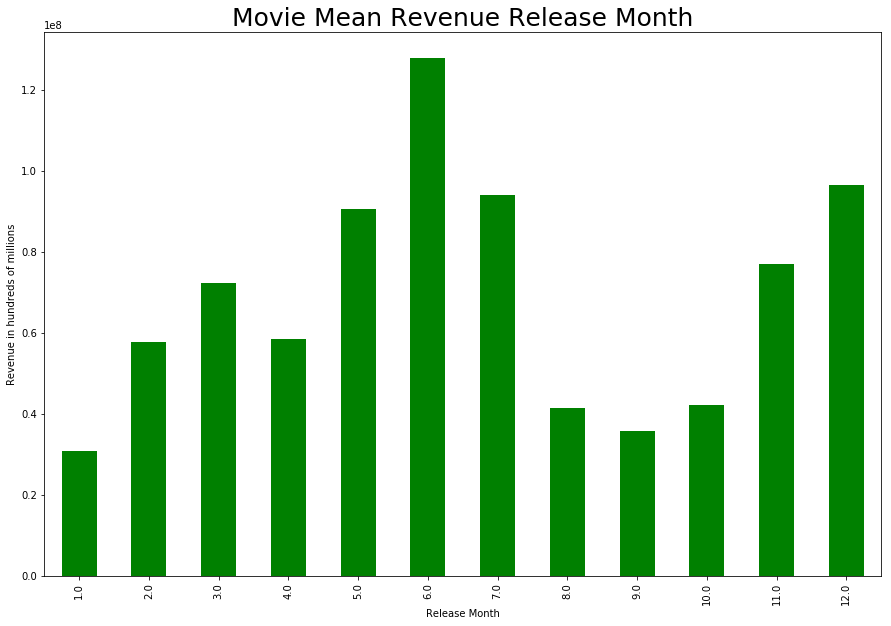

In [0]:
num_data["release_month"]=num_data['release_date']


#Here we find out the problem is actuallythat some dates are in a certain format while 
print("first date is in ", type(num_data["release_month"].iloc[0]),"format whereas the next date in the column is in", type(num_data["release_month"].iloc[1]) )

#With a for loop...
for i in range(len(num_data)):
  
  #if the date happens to be in string then, then we simply extract the first two digits and delete any backslash
  if type(num_data['release_date'].iloc[i]) == str:
    num_data.at[i,"release_month"]=num_data['release_date'].iloc[i][0:2]
    num_data.at[i,"release_month"]=int(num_data['release_month'].iloc[i].replace("/",""))
  else:
    #otherwise, we will take the month which here is wrongly inversed as the day
    num_data.at[i,"release_month"]=int(num_data['release_date'].iloc[i].day)

num_data["release_month"]=num_data["release_month"].astype(int)

#This one data point was wrong so we manually replace by the correct relase month
num_data.at[3828,"release_month"]=3
print(num_data[["title","release_month"]].head(8))

#We create this a column with only the first 3000 films for which we have the revenue for
movie_data["release_month"]=num_data["release_month"].iloc[0:3000]

#We group all the movies with the same months together and for each one calculate their mean
meanRevenueByMonth = movie_data.groupby("release_month")["revenue"].aggregate('mean')


#We create a barchart with Pandas' native function, putting the color as green because we are talking about money money ;)
meanRevenueByMonth.plot.bar(figsize=(15,10),color="g")

#Setting the barcharts titles and subtitles
plt.xlabel("Release Month")
plt.ylabel("Revenue in hundreds of millions")
plt.title("Movie Mean Revenue Release Month",fontsize=25)
plt.show()

Wow, so the data is clear, there seems to be a relationship between the month of the release and the revenue the movie pulled in. We can clearly see that the summer months of June and July gross higher than the others. This makes sense seeing as many blockbuster movies are released during the summer. Also December seems to be a good months for movies, probably due to the holiday season.

Any, this simple graph makes it very clear to us that we should definetely include the release month in our set of features.

Now, let's have a look at the day of the month in which the movie was relased, let's see if there are correlations there.

                                      title  release_day
Id                                                      
0                    Hot Tub Time Machine 2           20
1   The Princess Diaries 2 Royal Engagement            6
2                                  Whiplash           10
3                                   Kahaani            9
4                                Marine Boy            5
5    Pinocchio and the Emperor of the Night            6
6                            The Possession           30
7                              Control Room           15
1     877
2     852
12    278
9     263
6     262
11    262
10    261
7     255
3     253
8     230
5     216
15    206
13    198
16    195
4     192
14    188
18    188
22    178
25    174
21    172
24    172
28    170
17    169
19    166
20    162
26    158
30    157
23    155
27    152
29    140
31     97
Name: release_day, dtype: int64


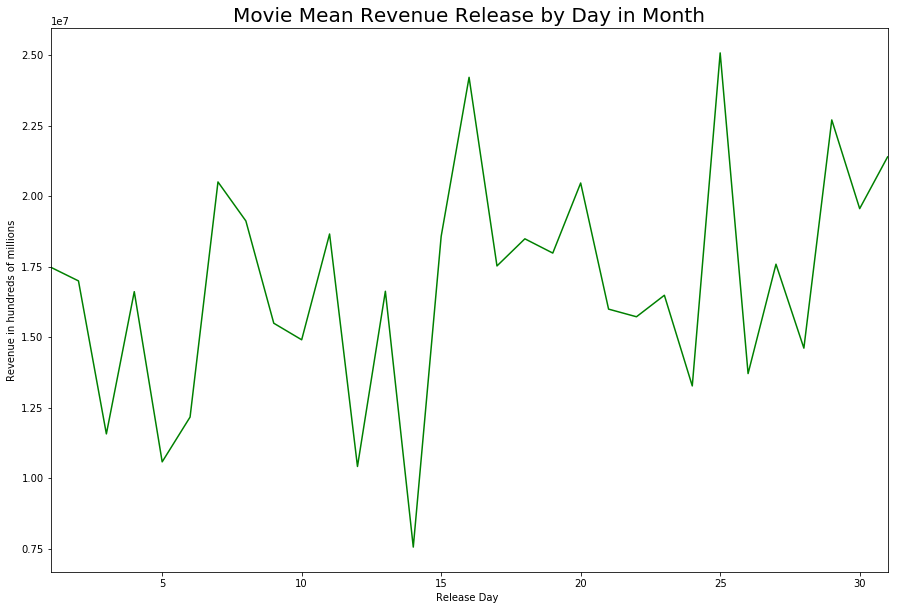

In [0]:
num_data["release_day"]=num_data['release_date']


#Same loop as above to correctly extract the mislabelled dates
for i in range(len(num_data)):
  if type(num_data['release_date'].iloc[i]) == str:
    num_data.at[i,"release_day"]=num_data['release_date'].iloc[i][2:4]
    num_data.at[i,"release_day"]=int(num_data['release_day'].iloc[i].replace("/",""))
  else:
    #The date is the wrong way round so in order to extract the date, we extract what is in reality the date
    num_data.at[i,"release_day"]=int(num_data['release_date'].iloc[i].month)

num_data["release_day"]=num_data["release_day"].astype(int)

num_data.at[3828,"release_day"]=21
print(num_data[["title","release_day"]].head(8))

movie_data["release_day"]=num_data["release_day"].iloc[0:3000]

print(num_data["release_day"].value_counts())

meanRevenueByDay = movie_data.groupby("release_day")["revenue"].aggregate('median')

#Here we want a simple graph chart so we can simply use the "plot" command
meanRevenueByDay.plot(figsize=(15,10), color='g')
plt.xlabel("Release Day ")
plt.ylabel("Revenue in hundreds of millions")
plt.title("Movie Mean Revenue Release by Day in Month",fontsize=20)
plt.show()

Interesting, from the data we have, it is clear that movies that are released in the middle or towards the end of the month tend to perform a lot better. It's unclear for me why that would be the case but it is clear there seems to be a pattern. Also, 40% of movies tend to be released on the 1st or 2nd of the month and so this might be skier the data. 

Perhaps we need to go deeper, and start looking at the days of the week to make sense of this 

Friday       2970
Thursday     1365
Wednesday    1140
Tuesday       540
Saturday      518
Sunday        445
Monday        420
Name: release_dayofweekbyname, dtype: int64


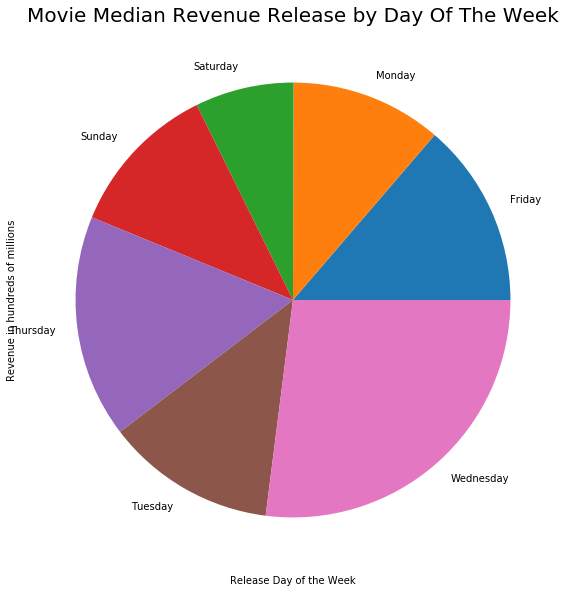

In [0]:
#Nowe that we'ver fixed the date we can replace the correctly formatted release dates with the previous ones.
num_data["release_date"]=num_data["release_year"].astype(str).str.cat(num_data["release_month"].astype(str),sep="-")

num_data["release_date"]=num_data["release_date"].astype(str).str.cat(num_data["release_day"].astype(str),sep="-")

#Convert the date to pandas date time format
num_data["release_date"]=pd.to_datetime(num_data['release_date'])

#Extract the day of the week using the pandas command ( the names)
movie_data["release_dayofweekbyname"]=num_data["release_date"].dt.day_name()

#Extracting the day of the week in numerical value (Monda=0, Tuesday=1 etc...)
num_data["release_dayofweek"]=num_data["release_date"].dt.dayofweek


#Let's see which is the most common
print(movie_data["release_dayofweekbyname"].value_counts())

movie_data["release_dayofweekbyname"]=movie_data["release_dayofweekbyname"].iloc[0:3000]


meanRevenueByDayofweek = movie_data.groupby("release_dayofweekbyname")["revenue"].aggregate('median')

#Let's put the data in a pie chart
meanRevenueByDayofweek.plot.pie(figsize=(15,10))
plt.xlabel("Release Day of the Week")
plt.ylabel("Revenue in hundreds of millions")
plt.title("Movie Median Revenue Release by Day Of The Week",fontsize=20)
plt.show()

Again, some pretty interesting insights. First, most movies are released on Friday. However, Wednesday releases are clearly the ones that gross the most. There is a clearer pattern to this data, so I reckon that we should use the day of the week rather than the days of the week.

In [0]:
#We scale the dates using the Absolute Scaler, because we don´t want to normalize using the mean, we want to conserve the original data.
num_data[['release_year','release_month','release_dayofweek']]=MaxAbsScaler().fit_transform(num_data[['release_year','release_month','release_dayofweek']])

#Drop the columns we decided we don´t want
num_data.drop(columns=['release_date','release_day'], inplace=True)

#Let´s have a look a that
num_data[['title','release_year','release_month', "release_dayofweek"]].head(8)

,title,release_year,release_month,release_dayofweek
Id,,,,
0,Hot Tub Time Machine 2,0.998513,0.166667,0.666667
1,The Princess Diaries 2 Royal Engagement,0.993062,0.666667,0.666667
2,Whiplash,0.998018,0.833333,0.666667
3,Kahaani,0.997027,0.250000,0.666667
4,Marine Boy,0.995540,0.166667,0.500000
5,Pinocchio and the Emperor of the Night,0.984638,0.666667,0.500000
6,The Possession,0.997027,0.666667,0.500000
7,Control Room,0.993062,0.083333,0.500000


### Spoken Language

Once again, the vast majority of movie will use English some point so that we classify the movies as speaking English or not. However what's interesting here is that we can also have a third option where a movie uses English as well as another language. We'll do this by creating two binary columns, and if both columns are marked as 1, then the movies uses both English as well as another language.

In [0]:
#Convert to string
num_data["spoken_languages"]=num_data["spoken_languages"].astype(str)

#Initiliaze empty columns
num_data["spoken_language_en"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))
num_data["spoken_language_non_en"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))

#If these strings are contained in the value
spoken_en=["English", "en"]

#Initiate a for loop
for i in range(len(num_data)):
  spoken_lang_count= num_data["spoken_languages"].iloc[i].count('name')
  spoken_langs=re.findall(r'[A-Z][a-z]*',num_data["spoken_languages"].iloc[i])
  #If the string of "English" is not contained or if there are multiple languages, then we know another language was used
  if not spoken_langs:
    num_data.at[i,"spoken_language_non_en"]=1
  if spoken_lang_count>1:
    num_data.at[i,"spoken_language_non_en"]=1
    
  #Simple for loop where if the string "English is contained", then we get mark that with a 1.   
  for lang in range(len(spoken_langs)):
    if spoken_langs[lang] in spoken_en:
      num_data.at[i,"spoken_language_en"]=1
    if spoken_langs[lang] not in spoken_en:
      num_data.at[i,"spoken_language_non_en"]=1

#Drop the column we no longer need.
num_data.drop(columns=['spoken_languages'], inplace=True)
  
#Let´s see what we see                                                 
num_data[['title','spoken_language_en','spoken_language_non_en']].head(8)


,title,spoken_language_en,spoken_language_non_en
Id,,,
0,Hot Tub Time Machine 2,1,0
1,The Princess Diaries 2 Royal Engagement,1,0
2,Whiplash,1,0
3,Kahaani,1,1
4,Marine Boy,0,1
5,Pinocchio and the Emperor of the Night,1,0
6,The Possession,1,0
7,Control Room,1,1


###Crew and Cast

Almost done with our data wrangling, the last thing we can look on our list is the "crew" and "cast" columns. Here for each column, we get a long string of crew ids and sometimes their names. This of course going to be very difficult for our model to make any sense of and we need to extract from it simple and yet insightful information. Let's have a look below first at what we're dealing with :

In [0]:
#Convert the columns to text format
num_data['crew'].astype(str,inplace=True)
num_data['cast'].astype(str,inplace=True)

#Let´s see what we´re dealing with
print(num_data['crew'].iloc[0])

[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 1451

In [0]:
#Let´s see what we´re dealing with
print(num_data['cast'].iloc[0])

[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character'

So looks like some nested dictionaries for each character which is of course a mess to make sense of, also some of these crew/cast members don't even have profile paths, so that will be impossible to get any further info on them... But hold on, the fact that certain cast/crew members have a profile paths and some don't is informative in itself. If a member of a crew or an actor has a dedicated profile on TMBD, that is no doubt an indicator of their fame and that surely will have a correlation to do with its economic performance. I think there are two pieces of data we can extract from these colums:



*   **The size of the crew and the cast (a further indication of budget) **
*   **How many "famous" people are in that crew or cast ( based on whether they have a profile path or not!)**


Let's get to it!


In [0]:
#Initializing four new columns
num_data["crew_size"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))
num_data["famous_crew"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))
num_data["cast_size"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))
num_data["famous_cast"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))


for i in range(len(num_data)):
  #Each crew member has a credit_id, so counting the number of time that words appears will give us the size of the crew
  crew_count=str(num_data['crew'].iloc[i]).count('credit_id')
  #Count how many crew members don´t have a profile path, ( with the string "None"), and so we count the number of non-famous crew members
  non_famous_crew_count=str(num_data['crew'].iloc[i]).count('None')
  #Same as above but for the cast colum
  cast_count=str(num_data['cast'].iloc[i]).count('cast_id')
  non_famous_cast_count=str(num_data['cast'].iloc[i]).count('None')
                
  num_data.at[i,"crew_size"]=crew_count
  #We can get the number of "famous" members but substracting the number of crew members that don´t have profiles to the total number of crew members
  num_data.at[i,"famous_crew"]=(crew_count)-(non_famous_crew_count)
  num_data.at[i,"cast_size"]=cast_count
  num_data.at[i,"famous_cast"]=(cast_count)-(non_famous_cast_count)
  
#Let´s see what we have
num_data[['title',"crew_size","famous_crew","cast_size","famous_cast"]].head(8)

,title,crew_size,famous_crew,cast_size,famous_cast
Id,,,,,
0,Hot Tub Time Machine 2,72,6,24,22
1,The Princess Diaries 2 Royal Engagement,9,6,20,19
2,Whiplash,64,5,51,20
3,Kahaani,3,0,7,6
4,Marine Boy,2,0,4,4
5,Pinocchio and the Emperor of the Night,11,2,4,3
6,The Possession,77,6,14,14
7,Control Room,1,0,4,3


In [0]:
#Of course, let's normalize all this data

num_data[["crew_size","famous_crew","cast_size","famous_cast"]]= StandardScaler().fit_transform(num_data[["crew_size","famous_crew","cast_size","famous_cast"]])



##Hyper famous actors

![alt text](https://m.media-amazon.com/images/M/MV5BMTM0ODU5Nzk2OV5BMl5BanBnXkFtZTcwMzI2ODgyNQ@@._V1_UY209_CR3,0,140,209_AL_.jpg)
![alt text](https://m.media-amazon.com/images/M/MV5BMTI3MDc4NzUyMV5BMl5BanBnXkFtZTcwMTQyMTc5MQ@@._V1_UY209_CR13,0,140,209_AL_.jpg)
![alt text](https://m.media-amazon.com/images/M/MV5BMTQwMjAwNzI0M15BMl5BanBnXkFtZTcwOTY1MTMyOQ@@._V1_UY209_CR15,0,140,209_AL_.jpg)
![alt text](https://m.media-amazon.com/images/M/MV5BMTQ3ODE2NTMxMV5BMl5BanBnXkFtZTgwOTIzOTQzMjE@._V1_UY209_CR14,0,140,209_AL_.jpg)
![alt text](https://m.media-amazon.com/images/M/MV5BMjI0MTg3MzI0M15BMl5BanBnXkFtZTcwMzQyODU2Mw@@._V1_UY209_CR7,0,140,209_AL_.jpg)
![alt text](https://m.media-amazon.com/images/M/MV5BMjIxNzc5MDAzOV5BMl5BanBnXkFtZTcwMDUxMjMxMw@@._V1_UY209_CR7,0,140,209_AL_.jpg)
![alt text](https://m.media-amazon.com/images/M/MV5BMTUwMTg4NDkzMV5BMl5BanBnXkFtZTYwMjU4Nzc2._V1_UY209_CR59,0,140,209_AL_.jpg)

Now, there is one last thing we can do. There are some actors that are famous enough to give the movie a box office boost. What I'm thinking is that if a movie contained one of the most famous actors on the planet, there should be a way for our model to know and to assess how this impacts the revenue. However, here we'll need an external source here, an objective list of the most famous actors in the world. [Here is the list I went for in the end.](https://www.imdb.com/list/ls052283250/)

The idea here is to extract the names from that page (using our good old BeautifulSoup library), and then once we have that list we can check whether any names in the cast matches our list of hyper famous actors. Let's give it a shot.





In [0]:
#Initialize empty list
list_of_stars=[]

#Obtain data from this link using Beautiful Soup
url = ('https://www.imdb.com/list/ls052283250/')
r2 = requests.get(url)
r2.url
star_page = str(BeautifulSoup(r2.text, 'lxml'))

#We find the keyword that precedes the name of the hyper famous actor
star_name_index=star_page.find("img alt=")



name_indices = []
index = -1  #Begin at -1 so index + 1 is 0
while True:
        # Find next index of substring, by starting search from index + 1
  index = star_page.find("img alt=", index + 1)
  if index == -1:  
    break  # All occurrences have been found
  name_indices.append(index)

# Using the regex to extract the Capitalized names which are obviously the Actor Names
for i in range(len(name_indices)):
    star_name_string= re.findall(r'[A-Z][a-z]*',star_page[name_indices[i]:name_indices[i]+33])
    list_of_stars.append(star_name_string)

# Join the Actor names together because we have extacted them as two seperate words
for i in range(len(list_of_stars)):
  sub_list= list_of_stars[i]
  list_of_stars[i]= ' '.join(sub_list)

      
#Deleting first parts of the list that are not actor names      
list_of_stars=list_of_stars[2:102]

list_of_stars

['Johnny Depp',
 'Arnold Schwarzenegger',
 'Jim Carrey',
 'Emma Watson',
 'Daniel Radcliffe',
 'Leonardo Di Caprio',
 'Tom Cruise',
 'Brad Pitt',
 'Charles Chaplin',
 'Morgan Freeman',
 'Tom Hanks',
 'Hugh Jackman',
 'Matt Damon',
 'Sylvester Stallone',
 'Will Smith',
 'Clint Eastwood',
 'Cameron Diaz',
 'George Clooney',
 'Steven Spielberg',
 'Harrison Ford',
 'Robert De Niro',
 'Al Pacino',
 'Robert Downey Jr',
 'Russell Crowe',
 'Liam Neeson',
 'Kate Winslet',
 'Mark Wahlberg',
 'Natalie Portman',
 'Pierce Brosnan',
 'Sean Connery',
 'Orlando Bloom',
 'Dwayne Johnson',
 'Jackie Chan',
 'Angelina Jolie',
 'Adam Sandler',
 'Scarlett Johansson',
 'Heath Ledger',
 'Anne Hathaway',
 'Jessica Alba',
 'Edward Norton',
 'Keira Knightley',
 'Bradley Cooper',
 'Will Ferrell',
 'Julia Roberts',
 'Nicolas Cage',
 'Daniel Craig',
 'Keanu Reeves',
 'Ian Mc Kellen',
 'Halle Berry',
 'Bruce Willis',
 'Samuel L Jackson',
 'Ben Stiller',
 'Tommy Lee Jones',
 'Antonio Banderas',
 'Denzel Washington',


Now that we have our list, we can start counting which movies feauture this superstars:

In [0]:
#Initialize empty column
num_data["num_of_stars"]= pd.DataFrame(0, index=range(len(num_data)), columns=range(1))

#This is a double for loop. For every actor name...
for star_name in tqdm(range(len(list_of_stars))):
  for i in range (len(num_data)):
    #We check for every movie if that actors´s name is in the movie´s cast. If it is then we will add a 1 to the movie´s number of stars
    if str(list_of_stars[star_name]) in str(num_data['cast'].iloc[i]):
      num_data.at[i,"num_of_stars"]=int(num_data["num_of_stars"].iloc[i])+1

      
num_data[['title','num_of_stars']].head(11)



100%|██████████| 100/100 [00:12<00:00,  8.35it/s]


,title,num_of_stars
Id,,
0,Hot Tub Time Machine 2,0
1,The Princess Diaries 2 Royal Engagement,1
2,Whiplash,0
3,Kahaani,0
4,Marine Boy,0
5,Pinocchio and the Emperor of the Night,0
6,The Possession,0
7,Control Room,0
8,Muppet Treasure Island,0


In [0]:
#Normalize the number of stars
num_data['num_of_stars']=StandardScaler().fit_transform(num_data[['num_of_stars']])

#Drop the last columns that we don´t need
num_data.drop(columns=['title','crew','cast'], inplace=True)

#num_data.to_excel('num_data_checkpoint_2.xlsx')

#files.download('num_data_checkpoint_2.xlsx')

#checkpoint 2

#num_data=pd.read_excel('https://github.com/busyML/Box-Office-Predictions/blob/master/num_data_checkpoint_3.xlsx?raw=true')

In [0]:
num_data.shape

(7398, 50)

#2 Neural Network time


So let's get into the juicy part of the this tutorial, which is to do with Neural Networks. There are lot of important element to Neural Networks so I'm going to operate with a FAQ approach where I'll go over the main elements of Neural Networks.

**What is a Neural Net?**

First of all, I'm going to use two pictures that explain a lot better explanations of  Neural Nets. The first picture shows the classic connected scheme, the data enters from the right, gets computed by internat activitions and weight computions until a final answer is spitted out on the other end.

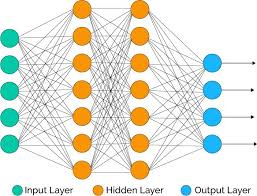

But a more subtle, cleaner understanding of Neural Nets resides in the second picturee, which basically show that Neural networks are a big composite function. A composite function is a function of the result of another function. For example f(g(x)) is a composite function. Each layer of a Neural net creates its on function that serves as the input for the next function. See for yourself:

![alt text](https://github.com/busyML/Box-Office-Predictions/raw/master/neuralnetcircles.PNG)



**Why do Neural Networks work well ?**

Before Neural Networks, Machine Learning relied on algorithms such as Linear Regression, Probalistic models and Support Vector Machines (SVMs). SVMs were the best performers but only on one condition. The machine trainer had to find the optimal way of transforming the data before putting it into the SVM algorithm. On some datasets, squaring the data (x^2) would give the best performance or in other cases reducing it by the natural log would be the best option. For each dataset of course, the trainer would have to manually try to guess what was the best transformation that needed to be applied to the data so that the algorithm would use it best, it was a tedious and very often, an impossible task. 

The groundbreaking approach of neural nets is that the neural nets, by virtue of having a hidden layera(s), learns for itself the best abstract representation to apply to the data before inferring from it. It basically optimized and automated the previous task I described. In a extremely simplistic way, neural nets learn the best way to pre-process the input data before learning the best way of predicting it. The more layers, the more complex problems and patterns the Neural Net is therefore able to decodify. This is why Neural Nets are considered the most powerful algorithms as of today. Which is not always a good thing...

**When should I use Neural Nets and when shouldn't I**

Neural use a lot of computational power and can train slower. This is the drawback to their superior performance. But in many instances, when our datasets are simple, traditional ML algorithms will perform just as good meaning the extra processing used to train the Neural Net. will have been a waste Just as a general rule of thumb, if your dataset has more than 50 columns and/or more than a 100,000 observations, you can start considering using a Neural Net. If you don't have data that large, then stick with traditional ML. Otherwise you might end up like this guy:

![alt text](https://i.kym-cdn.com/photos/images/original/001/449/433/3cb.jpg)

Data taken from texts and Images usually contain thousands or hundreds of thousands of feature column as we decrypt the text or image into numerical data. Here Neural Nets are your only option, they are by far the best algorithms for making inferences from text or images (using the appropriate architecture.)

TLDR: If your are dealing with text, audio or image data,  probably best that you use Neural Nets. If you are using large Numerical Data, you can try Neural Nets but it is possible that other algorithms outperform it  and if it's a smallish numerical dataset, using Neural Nets will not be advisable.

**How do we build a Neural Net**

Unless you are hermit, nobody builds Neural Networks in pure python. We use libraries that allow us to load up the most common types of Neural Nets and allow us to tweak and customize the elements that we want. The most popular library is called Tensorflow. Today, we are going to use a Library called Tflearn, which is even simpler to use and that will allow us to build Neural Nets in only a few lines of code.

**What are the key ingredients of Neural Networks**

No matter how simple libraries make our lives, there are certain ingredients of our Neural Network that we just have to define ourselves. There a three that stand out that we must always keep in mind:

***The loss function***: The loss function is what we use to measure the performance of the neural network. The neural network also uses the loss function to improves itself, it updates it's functions so that in the next iteration, it's loss function will be slightly better. The loss function is essentially how we calculate how close the neural net's answer was compared to the real answer. Without this loss function, our model could not operate. We usually choose our loss function based on the task we want our Neural Net to preform. If your task is classification, you would use one loss function (cross enntropy is the most common). Our taks is a regression problem (predicting the revenue of a movie), and so we'll used a loss function called RMSLE (in our case, the loss function was picked for us by the Kaggle competition). Here below, we will define it in code.


In [0]:

#this is the function in plain python. It basically calculates the log() difference between a prediction and the real answer. We´ll use to evaluate the performance of our model.
def rmsle(ypred, ytest) :
  assert len(ytest) == len(ypred)
  for i in range(len(ypred)):
    if ypred[i]<0:
      ypred[i]=0

  return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(ytest))**2))

#This is the same function but written for tensorflow so that we can use it in our library. 
def rmsle_for_tflearn(y_pred, y_true):
  y_pred= tf.cast(y_pred, tf.float32)
  y_true= tf.cast(y_true, tf.float32)
  y_pred=tf.nn.relu(y_pred)
  return  tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true))))

***The Network Architecture***: Next ingredient. The architecture is how the data flows in the data. The architecture defines how many layers we have and how many neurons each layer has. We can also get funky and use things like recurrent neural networks ( for predicting time series), Long Term Short Term (especially good for text generation) and convolutional neural networks ( for images). These are all specific architectures that we might one to pick based on the problem we are trying to solve. The more layers and neurons we add to our model, the better predictions on the training set should be. However, if we give it too much power, it will basically just memorize the training dataset but perform badly on the test data. Basically you want it to be a struggle, the model has to be powerful enough to memorize general patterns in the data ( that can be used in new data) but not so powerful it just memorizes the train data without an effort, meaning it will not know how to react to new type of data. Striking the balance here is... you guessed it... very difficult.

***The Hyperparameters***: And there is more balancing to do! There are some key parameters for our model that if not set correctly, will make our model perform all wrong. These are Learning Rate (too large or too small means that the model can't learn anything), the batch size (how many examples the neural nets sees at a time. Normally the smaller the better but slower it will be.), regularization (regularization is the healthiest way of "handicapping" a neural network so that it doesn't overfit the data and can generalize to new data). There are others, but for this intro, those are the hyperparameters that we'll focus the most on. I hope you starting to get a sense of the complexity of Neural Networks, which is why if you don't have to, don't use them!

That's enough theory. One learners best by doing so let's just get to it:

In [0]:
#we need to convert our data into a numpy array to pass into tflearn
num_train_data= np.array(num_data.iloc[0:3000])

#This is the submission data
num_test_data= np.array(num_data.iloc[3000:7398])

#We need to formated into a 1 dimensional array
target_data= np.array(movie_data['revenue'].iloc[0:3000])
target_data=np.reshape(target_data, (-1, 1))

#Just storing the dimensions of our dataset so that we can use them later
row_len,number_of_features= num_data.shape

print("Our dataset has", number_of_features, "feature columns.")


Our dataset has 50 feature columns.


So now that we´ve formatted our data, we start building our network. The Tflearn library makes it as simple as possible, every line of code is a layer of our network. Check the comments below for the implementation details for our dnn (deep neural network).

In [0]:
# This is our input layer, the gateway for our data. the entering dimension needs to be the number equal to the one of our dataset.
#dnn_net = tflearn.input_data(shape=[None, number_of_features])
#Drop out is a very efficient technique for regularization that improves the general performance. We usually place between our different layers
#dnn_net=tflearn.dropout(dnn_net,0.8)
#This is our first hidden layer. The "fully_connected" architecture is the classic one where all neurons are connected. 
#dnn_net = tflearn.fully_connected(dnn_net, n_units=768, activation="relu")#Here we will have 768 neurons and use the relu activation function (which the best default)
#dnn_net=tflearn.dropout(dnn_net,0.8)
#This is our second hidden layer, a carbon copy of the  first hidden layer. This just gives our model more firing power
#dnn_net = tflearn.fully_connected(dnn_net, n_units=768, activation="relu")
#dnn_net=tflearn.dropout(dnn_net,0.8)
#This is our output layer, that emits our prediction. It only has 1 unit because we are only predicting 1 number (the revenue of the movie)
#dnn_net = tflearn.fully_connected(dnn_net, n_units=1 , activation="linear")#activiation function is set to linear because this is a regression task
#This last feature passes the hyper-parameters. Regression that we are trying to reduce a loss function. If we wanted to generate sequences, we would choose another module (sequence generation for example)
#dnn_net = tflearn.regression(dnn_net, optimizer='adam', learning_rate=0.03, loss=rmsle_for_tflearn, batch_size=8) #The optimizer helps the model to learn efficiently. Adam is the most popular
#The optimal learning rate, after some trial and error seems to be 0.03 and because our dataset is very small ( only 3000 examples), we can affor a small batch size.

#This actually activates our model, think of it as flicking the "ON" button. Our model is now live and ready to learn
#dnn_model = tflearn.DNN(dnn_net)


In [0]:
#dnn_model.fit(num_train_data, target_data, n_epoch=25, snapshot_epoch=True, show_metric=False)

In [0]:
#train_preds=dnn_model.predict(num_train_data)
#test_preds=dnn_model.predict(num_test_data)

#print("training rmsle:", rmsle(train_preds,target_data))

#test_preds= pd.DataFrame(test_preds)


#test_preds.to_csv("numerical_submission.csv")
#files.download("numerical_submission.csv")


### Training

The code above uses the TFlearn library allows us to create and train our neural net of our numerical data. How did it go? Well to show you the a decision diagram I made that determines which next step we need to take during the ML training pipeline.

![alt text](https://github.com/busyML/Box-Office-Predictions/raw/master/Training%20Pipeline%20Decision%20Tree.png)

So let's go through how the steps went for us.

**Setting Performance Metric**: Here I'm going to set our objective RMSLE to 2.0. On the kaggle competition, the best score is 1.61, but this is a tutorial aimed at working on neural nets, and so we are not going to go too deep into findal a competition winning model. 2.0 is a fairly decent predictor score and could proably be used at production level.

**Training and Predicting on Train Data**: We trained the model on ths first 3000 examples ( given to us by the Kaggle competition). Training time was about 5 minutes. Then we ask our model to predict the revenue for these same 30000  example movies. Here we can think of this libeing a teacher. We gave some practice exercise to our student, corrected him when they were wrong and then the final exam we give them the same exercises obviously the exam will be easier for them. On the training data, the model made predictions that got a final score of **2.07**, this is pretty close to our performance metric, so we´ll deem it "good enough". This gives us some vital information, it means (1) our data is informative enough to get us the performance metric we set, (2) our model is powerful enough to extract patterns from it to make good enough predictions. So in our diagram, we would move from the "good enough" to the "predict on Test data" square.

**Predicting on the test data**: Coming back to the teacher/student analogy, this is like given the students an exam with exercises they have never seen before. This is obviously a far better assessment of overall ability. So we asked the model to predict the revenue of 4,397 movies it had never seen before. It´s first model gave us a rmsle score of **3.75**, obviously pretty terrible. When there is such a clear difference between training and test performance, this is a sure sign of overfitting. Following our diagram, we now know that we need to tweak our model so that it is more regularized. There are many ways we can do this, by using dropout, implementing weight decay. The first thing we tried was to decrease the batch size from the 32 default down to 8. This allows the model to learn with more detail because it updates it's weights after every 8 examples (rather than 32). The trade off is that training with smaller batches takes longer but because our dataset is only 3,000, it's  a small problem. After retraining with this implementation, our test prediction score plummeted to **2.23**, from which we can get a good feeling that the model is no longer overfitting. The simplest solution is often the best. We'll accept 2.23 score for now simply because we care about the performance about the final ensemble model. The key indicator for us at this stage was to make sure that there wasn´t a massive gap between the training and test performance.

We still have 2 more neural networks to train. 


##Deep Neural Network (DNN Network) with the Text data



So let's move on to our second data type, which is our text input, this is of course going to be looking at the title, the genres, the synopsis description and even the names of production company. 
The first thing that we'll do is to put all the strings of text into a single cell so that we end up with only two columns, one with the text we have for each movie and the other with revenue.







In [0]:
#We first retrieve the title name

nlp_title=movie_data["title"]

#Next we retrive the movie´s tagline
nlp_tagline=movie_data["tagline"]

#We count the number of movies that don´t have any associated taglines
print("there are",nlp_tagline.isna().sum(), "movies with no taglines")

#We replace all empty taglines with a blank space
nlp_tagline.fillna(" ", inplace=True)

#We double check that the nulls have been eliminated
assert nlp_tagline.isna().sum()==0


#We join the text in the two columns into the same one
nlp_data= pd.DataFrame( nlp_title.astype(str).str.cat(nlp_tagline.astype(str), sep= " , "))

#change column name
nlp_data=nlp_data.rename(columns={"title":"nlp_data"})

#Add revenue column
nlp_data["revenue"] = movie_data['revenue']

#Let´s see what we got
nlp_data.head(8)

there are 1460 movies with no taglines


,nlp_data,revenue
0,"Hot Tub Time Machine 2 , The Laws of Space and...",12314651.0
1,"The Princess Diaries 2 Royal Engagement , It c...",95149435.0
2,"Whiplash , The road to greatness can take you ...",13092000.0
3,"Kahaani ,",16000000.0
4,"Marine Boy ,",3923970.0
5,"Pinocchio and the Emperor of the Night ,",3261638.0
6,"The Possession , Fear The Demon That Doesn't F...",85446075.0
7,"Control Room , Different channels. Different t...",2586511.0


In [0]:
#Now we retrieve the synopsis description data, this will be our longest string
nlp_overview=movie_data["overview"]

#nlp_overview=nlp_overview.astype(str)

#We count the number of movies that don´t have any associated taglines
print("there are",nlp_overview.isna().sum(), "movies with no synopsis description")

#We replace all empty taglines with a blank space
nlp_overview.fillna(" ", inplace= True)

#We double check that the nulls have been eliminated
assert nlp_overview.isna().sum()==0
print("all null values removed")

#We add to the title and tagline the movie description.
nlp_data["nlp_data"]= nlp_data["nlp_data"].str.cat(nlp_overview.astype(str), sep= " , ")


nlp_data.head(8)


there are 22 movies with no synopsis description
all null values removed


,nlp_data,revenue
0,"Hot Tub Time Machine 2 , The Laws of Space and...",12314651.0
1,"The Princess Diaries 2 Royal Engagement , It c...",95149435.0
2,"Whiplash , The road to greatness can take you ...",13092000.0
3,"Kahaani , , Vidya Bagchi (Vidya Balan) arriv...",16000000.0
4,"Marine Boy , , Marine Boy is the story of a ...",3923970.0
5,"Pinocchio and the Emperor of the Night , , P...",3261638.0
6,"The Possession , Fear The Demon That Doesn't F...",85446075.0
7,"Control Room , Different channels. Different t...",2586511.0


In [0]:
#Retrieve and convert the genre column to string
nlp_genres = movie_data["genres"]
nlp_genres=nlp_genres.astype(str)

#with a for loop
for i in range(len(nlp_genres)):
  #we use regular expressions to only extract the names of the genres, ignoring the JSON metadata
  genre = re.findall(r'[A-Z][a-z]*',nlp_genres.iloc[i])
  #We join the multiple genres into one single string
  genre = " ".join(genre)
  #We assigne that string value to our column
  nlp_genres.at[i]= (genre)
  
print(nlp_genres.head(8))

#We add to the genre string to our nlp data.
nlp_data["nlp_data"]= nlp_data["nlp_data"].str.cat(nlp_genres.astype(str), sep= " , ")

0                         Comedy
1    Comedy Drama Family Romance
2                          Drama
3                 Thriller Drama
4                Action Thriller
5     Animation Adventure Family
6                Horror Thriller
7                    Documentary
Name: genres, dtype: object


In [0]:
#Next up are the Keywords, each movie as a unique set of keywords attached to them, I assume to help with search engine queries
nlp_keywords=(movie_data["Keywords"])

#We count the number of movies that don´t have any associated taglines
print("there are",nlp_keywords.isna().sum(), "movies with no keywords")

#We replace all empty taglines with a blank space
nlp_keywords.fillna(" ", inplace= True)

#We double check that the nulls have been eliminated
assert nlp_keywords.isna().sum()==0
print("all null values have been removed")

#the problem here is that the keywords also appear in miniscule, so they will be slightly harder to extract from JSON metadata


#we use a for loop
for i in range(len(nlp_keywords)):
  #we extract all text, thus deleting all brackets and paratheses
  keywords= re.findall(r'[a-z][a-z]*',nlp_keywords.iloc[i])
  keywords = " ".join(keywords)
  nlp_keywords.at[i]= (keywords)
  
#We eliminate the words "id" and "name", since these are not keywords  
nlp_keywords = nlp_keywords.str.replace("id","")
nlp_keywords = nlp_keywords.str.replace("name", "")

#We see that we only have the keywords left in our string
print(nlp_keywords.head(8))

#We add to the genre string to our nlp data.
nlp_data["nlp_data"]= nlp_data["nlp_data"].str.cat(nlp_keywords.astype(str), sep= " , ")


there are 669 movies with no keywords
all null values have been removed
0      time travel   sequel   hot tub   duringcredi...
1       coronation   duty   marriage   falling in love
2      jazz   obsession   conservatory   music teac...
3      mystery   bollywood   police corruption   cr...
4                                                     
5                                                     
6                                                     
7      journalism   translation   television   mani...
Name: Keywords, dtype: object


In [0]:
# Next we´ll create a string for the production country and the production company
nlp_production_country = movie_data["production_countries"]

nlp_production_country=nlp_production_country.astype(str)

#with a for loop
for i in range(len(nlp_production_country)):
  #we use regular expressions to only extract the country code names, to our model, it makes no difference whether we use the two letter code or the full name
  country = re.findall(r'\w*[A-Z]\w*[A-Z]\w*',nlp_production_country.iloc[i])
  #We join the multiple country codes into one single string
  country = " ".join(country)
  #We assign that string value to our column
  nlp_production_country.at[i]= (country)
  
#
nlp_production_country= nlp_production_country.str.replace("US", "USA")


print(nlp_production_country.head(8))

#We add to the genre string to our nlp data.
nlp_data["nlp_data"]= nlp_data["nlp_data"].str.cat(nlp_production_country.astype(str), sep= " , ")

#Retrieve the name of the production companies
nlp_production_companies= movie_data["production_companies"]

#We count the number of movies that don´t have any associated taglines
print("there are",nlp_production_companies.isna().sum(), "movies with no production")

#We replace all empty taglines with a blank space
nlp_production_companies.fillna(" ", inplace= True)

#We double check that the nulls have been eliminated
assert nlp_production_companies.isna().sum()==0
print("all null values were removed")

#convert to string
nlp_production_companies= nlp_production_companies.astype(str)

#with a for loop
for i in range(len(nlp_production_companies)):
  
  #This regular Expression allows to extract all text, upper and lower case, and filters out brackets etc.
  prod_compa= re.findall(r'[a-zA-Z]*',nlp_production_companies.iloc[i])
  prod_compa = " ".join(prod_compa)
  #We eliminate from the string the words name and id since they are also part of the metadata
  prod_compa=prod_compa.replace("name", "")
  prod_compa=prod_compa.replace("id", "")
  
  #The cleaned up string becomes our new value
  nlp_production_companies.at[i]= (prod_compa)

#Let´s see what we have
print(nlp_production_companies.head(8))
  
#We add to the production company string to our nlp data.
nlp_data["nlp_data"]= nlp_data["nlp_data"].str.cat(nlp_production_companies.astype(str), sep= " , ")



0       USA
1       USA
2       USA
3        IN
4        KR
5          
6    USA CA
7          
Name: production_countries, dtype: object
there are 414 movies with no production
all null values were removed
0            Paramount  Pictures                   ...
1                   Walt  Disney  Pictures            
2            Bold  Films                       Blum...
3                                                     
4                                                     
5                                                     
6            Ghost  House  Pictures                ...
7                                                     
Name: production_companies, dtype: object


In [0]:
#Finally, let´s view what a complete string for our movies look like
print(nlp_data["nlp_data"].iloc[0])


Hot Tub Time Machine 2 , The Laws of Space and Time are About to be Violated. , When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend. , Comedy ,   time travel   sequel   hot tub   duringcreditsstinger , USA ,         Paramount  Pictures                    United  Artists                     Metro  Goldwyn  Mayer   MGM                


Right, mission accomplished.

Now what we need to do is to transform the string to something that can be feed into the model. 

Here we´ll be using something called a TFid vectorizer.

This vectorizer does something very useful for us, it will discard both the words that are too recurrent ( such as a stop words like "the", "a", "them", etc.) and it will also filter out the words that only appear once and that are too rare to draw any inferrence off (think of  obscure names of places and foreign language words should get filtered out).

With the sklearn library, this is incredibly fast to implement as seen below:


In [0]:
#We download from nltk the list of pre-defined stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#we initialize the tfid vectorizer and choose the following hyperparameters
tfid_vectorization = TfidfVectorizer(min_df=2,  max_features=800, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 1), use_idf=2,smooth_idf=1,sublinear_tf=1, stop_words = stop_words)
#count_vectorization = CountVectorizer(min_df=2, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 1),  stop_words = "english")

#We apply our vectorizer to our test corpus
nlp_data = pd.DataFrame((tfid_vectorization.fit_transform(nlp_data["nlp_data"].values.astype('U'))).toarray())

#let´s see what we´ve got in our first row
print(*nlp_data.iloc[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0.19681590545945463 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2105087905981053 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.17300938238210414 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0871759646500299 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

what we see here is that our row text as been transformed to an array of numbers ( otherwise known as a vector), obviously it looks like gibberish to us but this format it actually the best for being read by our algorithm. Next, we just need seperate our data into training and testing and slightly reshaping.

In [0]:
#we need to convert our data into a numpy array to pass into tflearn
train_nlp_data= np.array(nlp_data.iloc[0:3000])
test_nlp_data = np.array(nlp_data.iloc[3000:7398])

#train_nlp_data=np.reshape(train_nlp_data, train_nlp_data.shape + (1,))
#test_nlp_data= np.reshape(test_nlp_data, test_nlp_data.shape + (1,))


row_num, number_of_features = train_nlp_data.shape



Here we'll use a similar neural network architecture, with a few differences than with the first one. As I'm sure you will have noticed, our row are extremely sparse ( containing many zeros). To deal with this, we'll put a low numbers of nodes, this serves a premptive regularizer.

In [0]:
# This is our input layer, the gateway for our data. the entering dimension needs to be the number equal to the one of our dataset.
#nlp_net = tflearn.input_data(shape=[None, number_of_features])
#nlp_net=tflearn.dropout(nlp_net,0.8)
#This is our first hidden layer. The "fully_connected" architecture is the classic one where all neurons are connected. 
#nlp_net = tflearn.fully_connected(nlp_net, n_units=120, activation="relu", weight_decay=0.01)#Here we will have 120 neurons because our dataset is very spartse
#This is our second hidden layer, a carbon copy of the  first hidden layer. 
#nlp_net = tflearn.fully_connected(nlp_net, n_units=120, activation="relu", weight_decay=0.01)#Here we will have 768 neurons and use the relu activation function (which the best default)
#This is our output layer, that emits our prediction. It only has 1 unit because we are only predicting 1 number (the revenue of the movie)
#nlp_net = tflearn.fully_connected(nlp_net, n_units=1 , activation="linear")#activiation function is set to linear because this is a regression task
#This last feature passes the hyper-parameters. 
#nlp_net = tflearn.regression(nlp_net, optimizer='adam', learning_rate=0.03, loss=rmsle_for_tflearn, batch_size=8) #The optimizer helps the model to learn efficiently. Adam is the most popular
#Activate
#nlp_model = tflearn.DNN(nlp_net, tensorboard_verbose=0)




In [0]:
#nlp_model.fit(train_nlp_data, target_data, show_metric=False, batch_size=8, n_epoch=12)


In [0]:
#nlp_training_preds=nlp_model.predict(train_nlp_data)

#nlp_test_preds=nlp_model.predict(test_nlp_data)

#print("training rmsle:", rmsle(nlp_training_preds,target_data))

#nlp_test_preds= pd.DataFrame(nlp_test_preds)

#nlp_test_preds.to_csv("nlp_submission.csv")

#files.download("nlp_submission.csv")

#nlp_training_preds= pd.DataFrame(nlp_training_preds)

#nlp_training_preds.to_csv("nlp_train_preds.csv")

#files.download("nlp_train_preds.csv")



### Training the Text Model

So how did our training go?

**First Training and Problem Diagnosing : **Well, the first time we trained our model, we got a staggeringly good score of **1.15** on the the training model. This means, according to our diagram above, that we proceed to the scoring the predictions on the test data, where we got **2.78**, which is a clear indication of overfitting. Here there is good news and bad news. The bad news is that whenever your model works well on your training data but not your testing data, we need to limit the capacity of model, through a process called **regularization** they are many ways that you can regularize, if you want to know more about these different techniques, I'll [link this concise video here](https://www.youtube.com/watch?v=NRCZJUviZN0). The good news when the model performs a lot better on the training data than on the testing data, it is usually a sign that our data and the way that we have pre-processed it is good enough and so to reduce this overfitting, we simply need more examples. In our case, because we are using movie data, there are plenty more movies that are available for us to add to our dataset. This means our pipeline and model are working well, we should just feed it more examples, for example training our model on 300,000 movies rather than the 3,000 currently. NLP does usually require large amounts of data, for example to crack the  English-French translation, the model needed 4 billions examples. However, because this is a Kaggle competition, collecting more data is simply not an option to us. :'( . Our only course of action will be through regularization.

**Second training:** Here we applied regularization through a combination of early stopping ( no in built function for this in Tflearn so we had to manually find the optimum number epochs) and weight decay ( the most powerful form of regularization). After applying these two, our performance on the trainin data was **2.68** and it was **2.84** on our testing data. Sure these scores are far from great, but because this is not our final model, we can leave them as is for now. The most important thing for us at this stage is that these two scores are as close as possible to one another so that our final model may confidently use it as consistent input in our final model. As long as our error margin is consistent, then those predictions will still be useful for our final model.

Enough of text data, let's move on to the movie posters!

## Convolutional Neural Network (CNN) for image data

![alt text](https://image.tmdb.org/t/p/w300/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg) ![alt text](https://image.tmdb.org/t/p/w300/7jDmWZW0C9nXEgsKNGs1nZT1EPv.jpg)  ![alt text](https://image.tmdb.org/t/p/w300/tu2rPoVBhEp9fZfOahkqbXSNsxS.jpg)
![alt text](https://image.tmdb.org/t/p/w300//xKGu7MQz9lxK3JGDFqQxxzMyfGH.jpg) ![alt](https://image.tmdb.org/t/p/w300//odrDjWF4LESn2tJXukmKRWyi1Vf.jpg) ![alt](https://image.tmdb.org/t/p/w300///ugVbrbicJHfOw8e24RUYISKqgvf.jpg)

Using Neural Networks on Data follows a different procedure than on numerical or lingustical data. This is maninly due to the size of the data being a lot bigger. 

This causes all sorts of complication, as for example, the simple matter of getting the data. We scraped the movie posters as follows:

Each movie has a movie poster path, so we had to download it via code in this fashion.



In [0]:
import urllib
import requests

#we create a sinmple function that can download images from a specific url and that gives the file the appropriate name.
def download_image(url):
    name = url.replace("https://image.tmdb.org/t/p/w300/","")
    fullname = str(name)+".jpg"
    urllib.request.urlretrieve(url,fullname)
    files.download(fullname)
    
    return fullname
    
   
#We simply pass the url through this function 
download_image("https://image.tmdb.org/t/p/w300/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg")

#Saving it to local memory
urllib.request.urlretrieve("https://image.tmdb.org/t/p/w300/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg","lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg")




('lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg',
 <http.client.HTTPMessage at 0x7f6dbb523198>)

Using this function as a for loop, we were able to download every single movie poster. This took approximately 4 hours.

Once we have the pictures, we need to create a seperate document where the name of each file and its corresponding revenue is stored. This is the format that TFlearn expects. It needs to know in a simple text file, which movies are related to which movie. Once we pass this function, TFlearn library will do the rest for us. As you can imagine, this is an incredibly useful feature.

In [0]:
files.upload()

{}

So now that our path pointers are loaded, we need to actually load our images to memory. This would usually be very quick but because we are working on the Colab lab, we first need to upload all these images to the cloud will take 2 hours. But here it is in case you are of the patient.

*Download these two folder and them upload them through the upload method : [Training pictures folder](https://drive.google.com/drive/folders/13_toQyWtechD96s_f6nlMkudAO-xR9I4?usp=sharing) and [ Testing pictures folder](https://drive.google.com/drive/folders/1aIPmiOvfiWYPHUkXQn0JJ_KFR2Xi-JaD?usp=sharing)

###The curse of image data...

Finally, we can now make our model. 

Here we are going to be using a Convolutional Neural Network. CNNs, in many ways, are the first neural networks that validaded the architecture approach, when been able, back in the 90s, to recognize hand written digits. 

Without going too deep, CNN work by first looking at the entire picture and finding specific features such as lines or shapes. Then it zooms into that space and passes it on to the next layer which repeats the process but on a more specific section on the data. CNNs are the most models to use with picture data. Here is a diagram of how it works:

![alt text](https://cdn-images-1.medium.com/fit/t/1600/480/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

And on the math side:

![alt text](https://cdn-images-1.medium.com/max/1600/1*7S266Kq-UCExS25iX_I_AQ.png)


However, this all well and good, but we have a fairly big problem:  as you can imagine, we don´t really have enough data for the model to learn useful representations. If we were using 300,000 movie posters instead of 3,000 we might stand a chance, but CNNs are notorious for needing large amounts of data to learn from. In fact, just to be certain, I used the CNN architecture on our movie posters and the model only made predictions that were between 7,000,000 and 10,000,000, which was the only way it could find to minimizing the loss. It still gave us a terrible performance of **3.3**.

However, in machine learning and in life, there is always a solution to every problem. And here the name of the solution is transfer learning. Transfer learning is a simple and powerful concept: build on the shoulders of giants. Giant models that is. Transfer learning import a preexisting model that has already been trained on millions on images and we repurpose this neural net model for our own needs.

Here we´ll import from the awesome Keras library the VGG19 model that was trained by the google team on the Image net library to classify thousands of objects. It already has some good notion of deciphering what a picture contains and this will be very handy. 
However, we need to make a crucial tweak. We are going to cut of the last part of the model, as you can see on the picture below:

![alt text](https://cdn-images-1.medium.com/max/1600/1*qfQ3hmHLwApXZBN-A85r8g.png)




[Here some great explanation on how to use transfer learning, really well laid info.](http://cs231n.github.io/transfer-learning/)






In [0]:
#we import everythimng we need from keras, including the full pre-trained model that we can just call with the ".predict" command
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model

#Here we specify that we want the weights that the model learned from training on the imagenet dataset
base_model = VGG19(weights='imagenet')

#Here we´ll use the last layer of CNN before the classification model is made. This layer is called "fc2" 
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

Using TensorFlow backend.


This means that we will use the pre-trained on our pictures and it will output a 1x4096 vector for every single picture. These number are a representation of the different element the CNN has identified in the picture and the original model will pass it on the final layer which uses this info to select which object the picture contains. However, we´ll use these 4096 features are predictors for the box office revenue. Smart right.

After upload all our 7 398movie posters (3,000 for training, 4,398 for testing), we ask our imported pre-trained model to make an inference on them. We then end up with huge DataFrame of 7398x4096. This what we´ll use to make predictions from.

In [0]:
#Here is an example with this picture we previously downloaded
img_path = 'lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg'
#We reshape the picture to the expected size
img = image.load_img(img_path, target_size=(224, 224))
#converting to numbers so that we can input it to the cnn
img = image.img_to_array(img)
#Add a dimension
img = np.expand_dims(img, axis=0)
#And carry out some basic pre processing
img = preprocess_input(img)

#carry out prediction as an examples
cnn_output_example = pd.DataFrame(model.predict(img))

print(cnn_output_example.shape)

cnn_output_example

(1, 4096)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.785943,2.296072,0.0,0.0,1.440322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.562023,0.176143,0.0,0.0,0.0,0.0,0.0,0.0,0.339426,0.190857,0.503495,0.0,0.0,0.0,0.0,0.293511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.419414,0.0,0.0,0.0,3.55101,0.0,0.0,0.609772,0.0,0.592878,1.53521,0.0,0.0,0.0,0.756505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009819,3.681045,2.862475,2.426409,0.0,0.0,0.0,0.0,0.0


In [0]:
#we create a dataframe to store all the movie poster paths
img_data= movie_data["poster_path"]
img_data = img_data.str.replace("/","")

img_data = img_data.astype(str)

In [0]:
#This dataframe will contain all features extracted from the CNN with 4096 columns
extracted_features = pd.DataFrame(0, index=range(1), columns=range(4096))

In [0]:
#We carry out the pre trained model prediction for every single movie poster in our dataset.
#for i in tqdm(range(len(img_data))):
# img_path = img_data.iloc[i]
 #img = image.load_img(img_path, target_size=(224, 224))
  #x = image.img_to_array(img)
  #x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  
  #img_extracted_features = model.predict(x)
  
  #img_extracted_features
  
  #extracted_features=extracted_features.append(pd.DataFrame(img_extracted_features))
  
  
  
  

We´ve commented out this code because to run it on the 7,000 movie posters takes a couple of hours. Rather, I´d recommend that [you download the "extracted_feature" dataset from here](https://drive.google.com/file/d/1HPamWUqupQIXGr-DbVUsG2dsjz6oFSzL/view?usp=sharing) and upload it to the colab if you want to run the code on it. 

In [0]:
#files.upload
#extracted_features.to_csv("extracted_features.csv")

In [0]:
#Deleting some uneeded rows and columns
extracted_features = extracted_features.iloc[1:]

extracted_features = extracted_features.drop(columns=["Unnamed: 0"])

extracted_features.shape



KeyError: ignored

In [0]:
extracted_features
  


In [0]:
#seperating into training and testing data
img_train_data=np.array(extracted_features.iloc[0:3000])

img_test_data=np.array(extracted_features.iloc[3000:7398])

row_size, number_of_features = img_train_data.shape


 It´s usually the case to use a simple linear model on this such as an SVR or Random Forest, however seeing as we´re practicising Nueral Nets here , we´ll use a simple double layers Feed Forward neural net to make inference from it. (it´s quite possible that a SVM might work better after applying PCA to the data)) This time we´ll be using the Keras library just so you can get a taste of another super useful library for running neural nets:


In [0]:
#def build_img_model():
  #img_model = keras.Sequential([
    #layers.Dense(512, activation='relu', input_shape=[4096]),#, kernel_regularizer=keras.regularizers.l2(l=0.0)),
    #layers.Dropout(0.2, noise_shape=None, seed=None),
    #layers.Dense(512, activation='relu', ),# kernel_regularizer=keras.regularizers.l2(l=.0)),
    #layers.Dropout(0.2, noise_shape=None, seed=None),
    #layers.Dense(1)
  #])

  #optimizer = tf.keras.optimizers.Adam(0.0005)

  #img_model.compile(loss="mean_squared_logarithmic_error",
                optimizer=optimizer)
  #return img_model

In [0]:
#img_model = build_img_model()
#img_model.fit(img_train_data, target_data, epochs=25, batch_size=8)

In [0]:
#training_img_preds=img_model.predict(img_train_data)

#test_preds=img_model.predict(num_test_data)

#print("training rmsle:", rmsle(training_img_preds,target_data))

#training_img_preds= pd.DataFrame(training_img_preds)


So after training, our performance on the training is 2.74 whereas on the testing (submitted to Kaggle) is 2.96. That´s an acceptable margin of difference but most important thing is that our predictions are actually ranging from very low to very high numbers, just like in our target dataset. We can infer from this that the model indeed found some could indicators of high or low revenue from those 4096 columns extracted from the data. Those patterns were probably not strong enough to learn consistent trends, and so more data here would most likely improve our performance. If we weren´t in a restricted environment, our next course of action would be collect more data. But here we´ll accept this low performance since we know that it will only be one of the inputs in our final model,
Talking of which, the time has come to combine the predictions of our three previous models into on. The Master model will only take three inputs and will give us our best results yet…

# Master Model

This model will be very simple and will only take in 3 inputs, the first being the prediction made by the CNN, the second by the NLP and the third from the Numerical Model that we built at the start. This big moment as come. I previously agregated the three predictions from the other models into one simple model as you can see below.

In [0]:

#this is the function in plain python. It basically calculates the log() difference between a prediction and the real answer. We´ll use to evaluate the performance of our model.
def rmsle(ypred, ytest) :
  assert len(ytest) == len(ypred)
  for i in range(len(ypred)):
    if ypred[i]<0:
      ypred[i]=0

  return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(ytest))**2))

#This is the same function but written for tensorflow so that we can use it in our library. 
def rmsle_for_tflearn(y_pred, y_true):
  y_pred= tf.cast(y_pred, tf.float32)
  y_true= tf.cast(y_true, tf.float32)
  y_pred=tf.nn.relu(y_pred)
  return  tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true))))

In [3]:
#Load the small dataset from Github where it was stored
master_data = pd.read_csv("https://github.com/busyML/Box-Office-Predictions/raw/master/master_model_data.csv")

#Let´s see what we´ve got
master_data.head(8)

,id,image data,nlp data,num_data,revenue
0,0,9474910.00,18266984.0,2.910534e+07,12314651
1,1,17163082.00,12540511.0,9.380182e+07,95149435
2,2,14086309.00,6238081.5,2.452248e+08,13092000
3,3,17597708.00,9775520.0,2.862744e+06,16000000
4,4,4827690.50,3949938.5,1.245193e+06,3923970
5,5,2467343.50,6541385.5,4.216039e+06,3261638
6,6,13415480.00,10186158.0,1.284862e+07,85446075
7,7,495292.94,2786380.8,1.448867e+05,2586511


Then, we just need to do a bit of preprocessing, seperating the taget column "revenue" and breaking our dataset into train and test. Nothing we haven´t done before. 

In [0]:
#Dropping the two columns we don´t need
master_data = master_data.drop(columns=["revenue","id"])

#Seperating and formating the dataset
master_data_train = np.array(master_data.iloc[0:3000])

master_data_test = np.array(master_data.iloc[3000:7398])

Next, we initialize a simple neural, which will only take 3 inputs

In [0]:
master_net = tflearn.input_data(shape=[None, 3])
#master_net=tflearn.dropout(master_net,0.8)
master_net = tflearn.fully_connected(master_net, n_units=300, activation="relu")
#master_net=tflearn.dropout(master_net,0.5)
master_net = tflearn.fully_connected(master_net, n_units=300, activation="relu")
master_net=tflearn.dropout(master_net,0.5)
master_net = tflearn.fully_connected(master_net, n_units=1 , activation="linear")
master_model = tflearn.regression(master_net, optimizer='adam', learning_rate=0.0001, loss=rmsle_for_tflearn, batch_size=8)
master_model = tflearn.DNN(master_net)


In [8]:
master_model.fit(master2_data_train, target_data, n_epoch=10)

Training Step: 3749  | total loss: 1.48473 | time: 2.250s
| Adam | epoch: 010 | loss: 1.48473 -- iter: 2992/3000
Training Step: 3750  | total loss: 1.51222 | time: 2.256s
| Adam | epoch: 010 | loss: 1.51222 -- iter: 3000/3000
--


In [9]:
master_predictions = master_model.predict(master_data_train)
print("rmsle master:", rmsle(master_predictions, target_data))

rmsle master: 2.3082529540927683


In [0]:
#master_submission = pd.DataFrame(master_model.predict(master_data_test))

#master_submission.to_csv("master_submissions.csv")


We got a RMSLE score of 2.07 on our training data and then on the test data (scored by Kaggle), we got 2.26. This means that on average our Neural Net makes a mistake that is less than 1,000,000. Our model could now be used by production companies when planing which movies to finance.

##Conclusion

Our model is by far from being optimal, many people have obtained higher scores by using more sophisticated models and incorporating external datasets. The aim of the this tutorial was to familiazrize you with using the TFlearn and Keras library for creating basic feedforward neural network and even with those simple neural nets we end up with a decent performance ( that could be enhanced if more data was permitted.).

The main topics seen in this tutorials were (in order of appearance) :



*   **Pre-processing numerical data**
*   **Webscraping extra features**
*   **Using the TFlearn library**
*   **Pre processing text (nlp)**
*   **Using transfer learning on image data**

If you have obtained a theoritical grasp on these concepts, then bravo bravo, you are well on your way to being able to use Neural Networks on a daily basis. All that´s left if that you start practicising as much as you can. Pick a dataset that genuinely interests you and get to work :)

Anyway questions about the tutorial, feel free to email me at [conrad.w.s@gmail.com](mailto:conrad.w.s@gmail.com)

